## Preprocessing

In [98]:
import pandas as pd
from sklearn.model_selection import train_test_split

def collapse_genus_features(df):
    """
    Collapse columns like 'Bacteroides1', 'Bacteroides7' → 'Bacteroides'
    by summing all ASVs per genus. Remove columns named 'UnknownGenus'.
    """
    # Store label and remove unnecessary columns
    label = df['label'] if 'label' in df.columns else None
    cols_to_drop = ['label1', 'label.1', 'batch', 'batch1', 'Unnamed: 0']
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')

    # Drop label column for collapsing
    df_no_label = df.drop(columns='label', errors='ignore')

    # Extract genus names (remove trailing numbers)
    new_col_names = df_no_label.columns.str.extract(r'(^[A-Za-z_]+)', expand=False)
    df_no_label.columns = new_col_names

    # Collapse by genus
    collapsed_df = df_no_label.groupby(df_no_label.columns, axis=1).sum()

    # Remove genus columns named 'UnknownGenus' (case insensitive)
    cols_to_remove = [col for col in collapsed_df.columns if str(col).lower() == 'unknowngenus']
    collapsed_df = collapsed_df.drop(columns=cols_to_remove, errors='ignore')

    # Reattach label
    if label is not None:
        collapsed_df['label'] = label.values

    return collapsed_df

# Load your dataset
df = pd.read_csv("C:/Users/YLS/Documents/FinalDataIBD.csv")

# Collapse genus-level features and clean
collapsed_df = collapse_genus_features(df)

# Split into training and test sets
train_df_clean, test_df_clean = train_test_split(collapsed_df, test_size=0.2, random_state=42, stratify=collapsed_df['label'])

# Save collapsed full dataset and splits
collapsed_df.to_csv("C:/Users/YLS/Documents/collapsed_IBD.csv", index=False)
train_df_clean.to_csv("C:/Users/YLS/Documents/clean_train.csv", index=False)
test_df_clean.to_csv("C:/Users/YLS/Documents/clean_test.csv", index=False)


C:\Users\YLS\AppData\Local\Temp\ipykernel_25524\2285420745.py:22: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  collapsed_df = df_no_label.groupby(df_no_label.columns, axis=1).sum()


In [27]:
df['label'].value_counts()

label
1    950
0    336
Name: count, dtype: int64

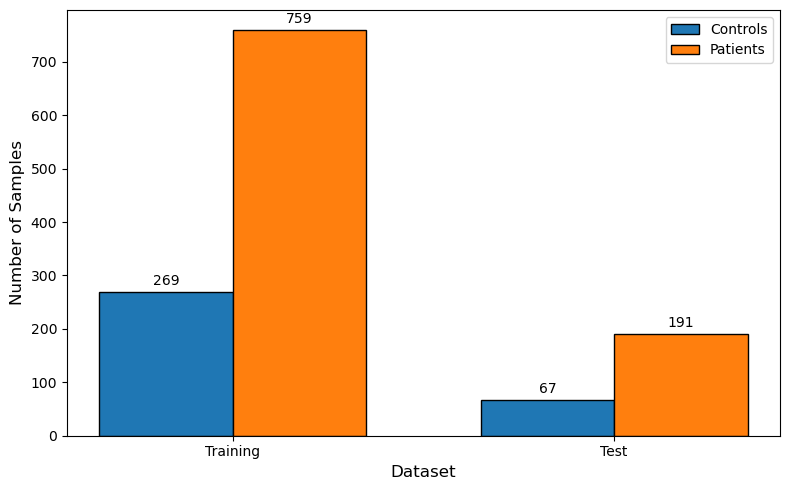

In [102]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
train_counts = train_df_clean['label'].value_counts().sort_index()
test_counts = test_df_clean['label'].value_counts().sort_index()

x = np.arange(2)  # 2 groups: Training and Test
width = 0.35  # Width of bars

fig, ax = plt.subplots(figsize=(8, 5))

# Plot controls (label 0)
rects1 = ax.bar(x - width/2, [train_counts[0], test_counts[0]], width, 
               label='Controls', color='#1f77b4', edgecolor='black')

# Plot patients (label 1)
rects2 = ax.bar(x + width/2, [train_counts[1], test_counts[1]], width, 
               label='Patients', color='#ff7f0e', edgecolor='black')

# Add labels and titles
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_xlabel('Dataset', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(['Training', 'Test'])
ax.legend(fontsize=10)

# Add exact counts on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

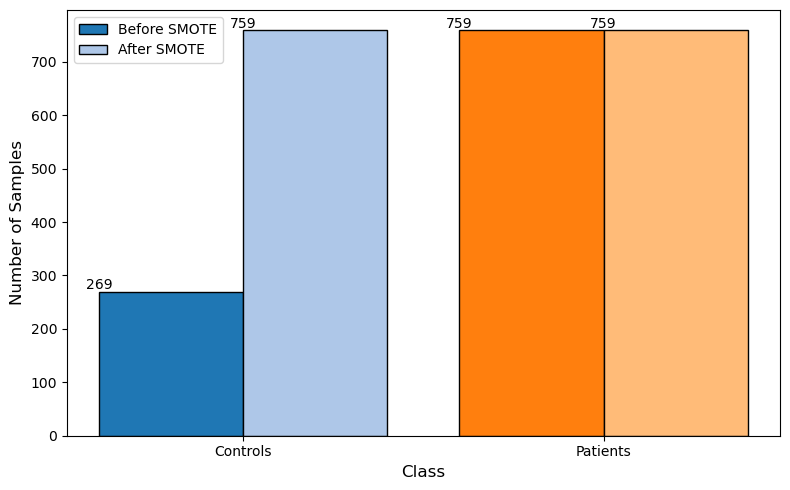

In [104]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(train_df_clean.drop(columns='label'), train_df_clean['label'])
smote_counts = pd.Series(y_res).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 5))

# Before SMOTE
ax.bar([0, 1], train_counts, width=0.4, 
       label='Before SMOTE', color=['#1f77b4', '#ff7f0e'], 
       edgecolor='black')

# After SMOTE (shifted right)
ax.bar([0.4, 1.4], smote_counts, width=0.4, 
       label='After SMOTE', color=['#aec7e8', '#ffbb78'], 
       edgecolor='black')

# Formatting
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_xlabel('Class', fontsize=12)
ax.set_xticks([0.2, 1.2])
ax.set_xticklabels(['Controls', 'Patients'])
ax.legend(fontsize=10)

# Add counts
for i, count in enumerate(train_counts):
    ax.text(i - 0.2, count + 5, f'{count}', ha='center', fontsize=10)
for i, count in enumerate(smote_counts):
    ax.text(i + 0.2, count + 5, f'{count}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## Plot abundances

C:\Users\YLS\AppData\Local\Temp\ipykernel_25524\1482551924.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Mean'] = filtered_df.mean(axis=1)


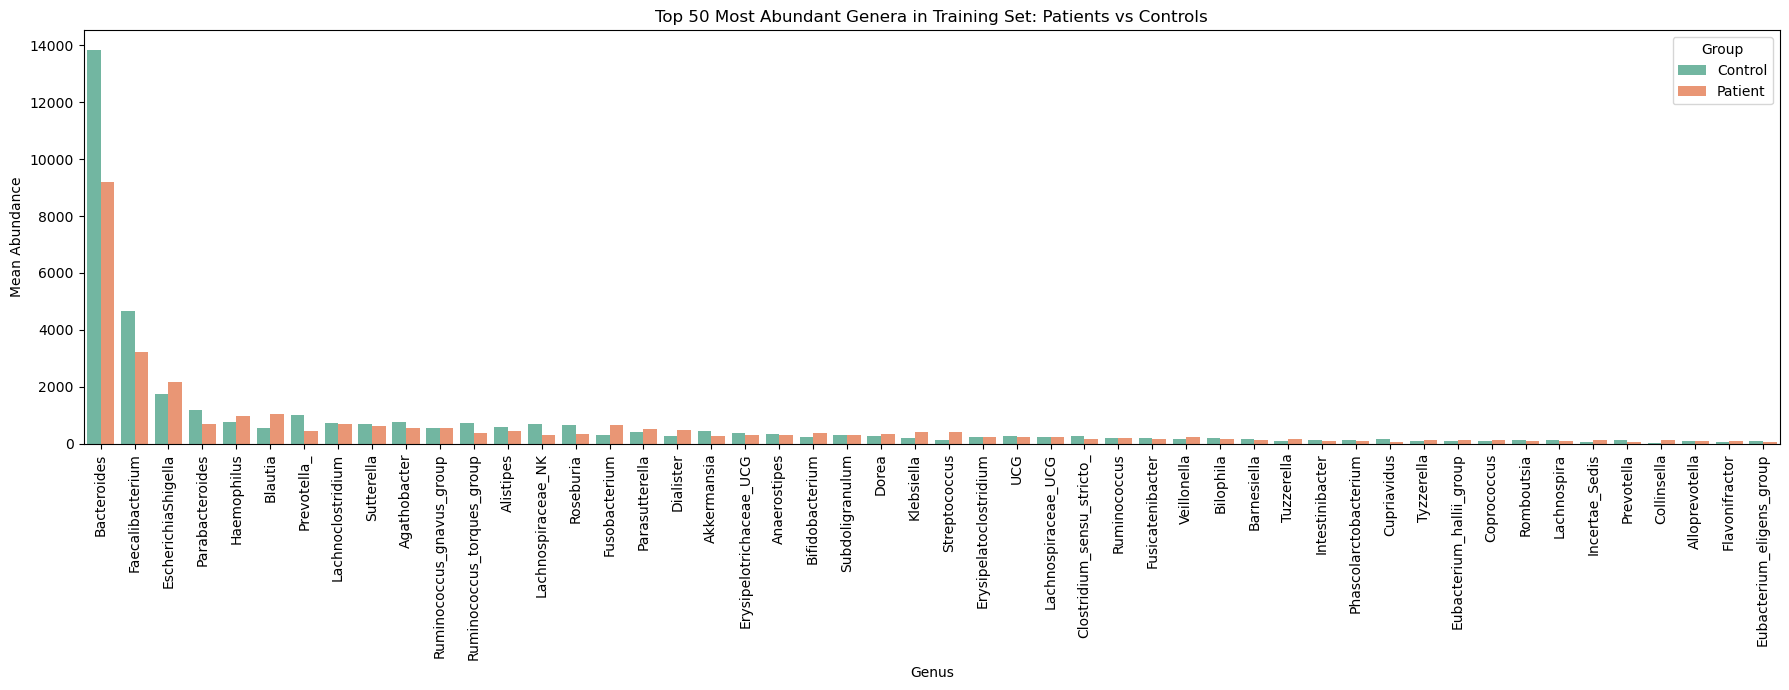

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load training data from previous step
train_df_clean = pd.read_csv("C:/Users/YLS/Documents/clean_train.csv")

# Ensure label column is treated as string
train_df_clean['label'] = train_df_clean['label'].astype(str)

# Split by class label
controls = train_df_clean[train_df_clean['label'] == '0'].drop(columns='label')
patients = train_df_clean[train_df_clean['label'] == '1'].drop(columns='label')

# Compute mean abundance per genus
control_means = controls.mean()
patient_means = patients.mean()

# Combine into a single dataframe
combined_df = pd.DataFrame({
    'Control': control_means,
    'Patient': patient_means
})

# Filter out extremely low abundance genera
filtered_df = combined_df[(combined_df['Control'] > 1e-6) | (combined_df['Patient'] > 1e-6)]

# Compute average abundance and select top 50 genera
filtered_df['Mean'] = filtered_df.mean(axis=1)
top50_df = filtered_df.sort_values('Mean', ascending=False).drop(columns='Mean').head(50)

# Prepare for Seaborn plot
plot_df = top50_df.reset_index().melt(id_vars='index', var_name='Group', value_name='Mean Abundance')
plot_df.rename(columns={'index': 'Genus'}, inplace=True)

# Plot
plt.figure(figsize=(18, 7))
sns.barplot(data=plot_df, x='Genus', y='Mean Abundance', hue='Group', palette='Set2')
plt.xticks(rotation=90)
plt.title("Top 50 Most Abundant Genera in Training Set: Patients vs Controls")
plt.tight_layout()
plt.show()


### Plot of the abundances of the genus filtered

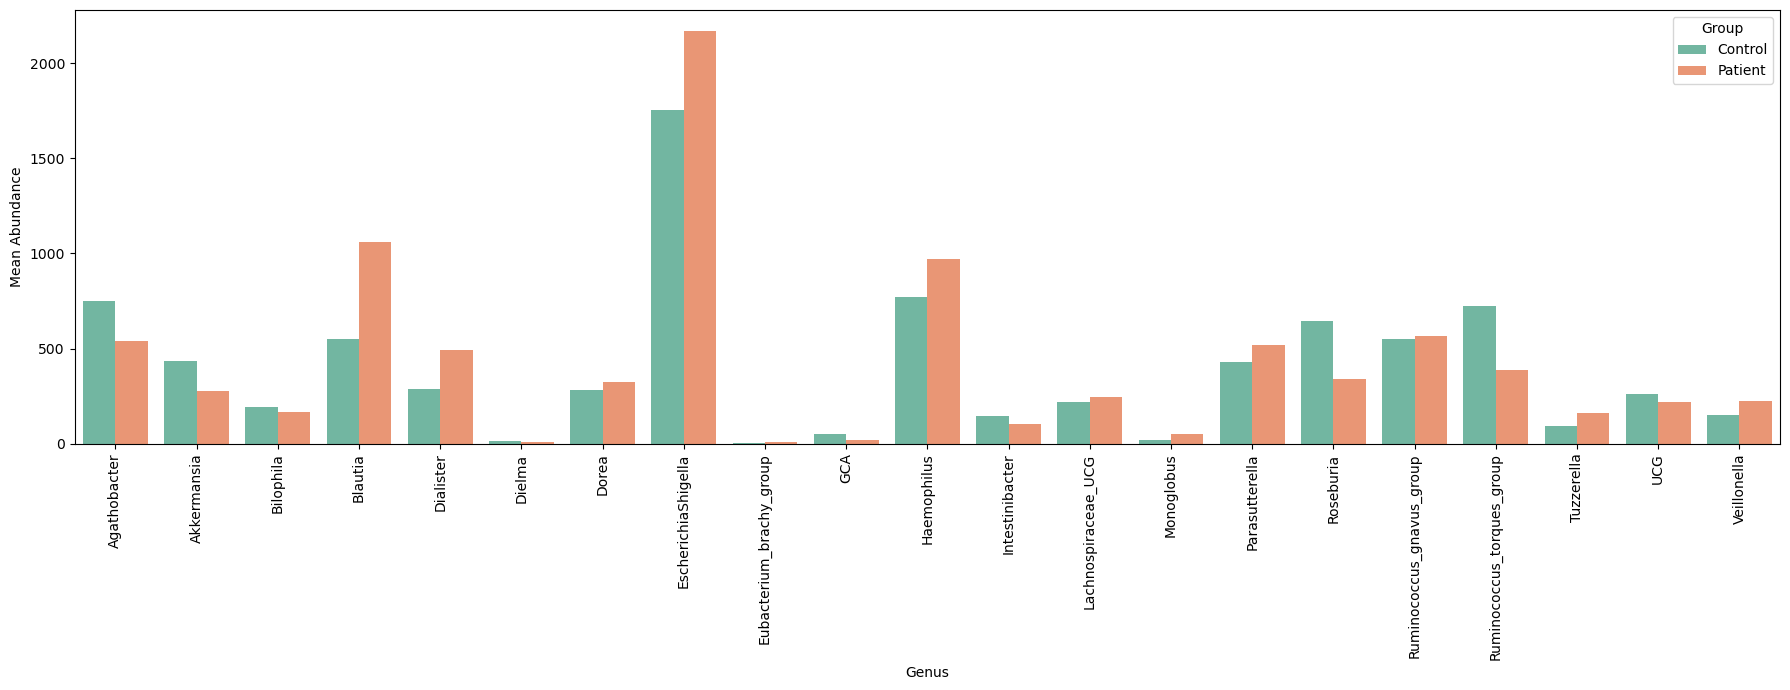

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load training data from previous step
train_df_clean = pd.read_csv("C:/Users/YLS/Documents/clean_train.csv")

# Ensure label column is treated as string
train_df_clean['label'] = train_df_clean['label'].astype(str)

# Split by class label
controls = train_df_clean[train_df_clean['label'] == '0'].drop(columns='label')
patients = train_df_clean[train_df_clean['label'] == '1'].drop(columns='label')

# Compute mean abundance per genus
control_means = controls.mean()
patient_means = patients.mean()

# Combine into a single dataframe
combined_df = pd.DataFrame({
    'Control': control_means,
    'Patient': patient_means
})

# List of specific bacteria genera to plot
target_genera = [
    'Roseburia', 'Dorea', 'Dielma', 'Lachnospiraceae_UCG', 'UCG',  'Dialister','Blautia', 
    'Intestinibacter', 'GCA', 'Tuzzerella', 'Agathobacter', 'Veillonella', 
    'Ruminococcus_gnavus_group', 'Haemophilus', 'Bilophila', 
    'Akkermansia', 'EscherichiaShigella', 'Eubacterium_brachy_group',
    'Ruminococcus_torques_group', 'Monoglobus', 
    'Parasutterella'
]

# Filter the dataframe to include only the target genera
filtered_df = combined_df[combined_df.index.isin(target_genera)]

# Prepare for Seaborn plot
plot_df = filtered_df.reset_index().melt(id_vars='index', var_name='Group', value_name='Mean Abundance')
plot_df.rename(columns={'index': 'Genus'}, inplace=True)

# Plot
plt.figure(figsize=(18, 7))
sns.barplot(data=plot_df, x='Genus', y='Mean Abundance', hue='Group', palette='Set2')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

C:\Users\YLS\AppData\Local\Temp\ipykernel_25524\2628812400.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90,fontsize=13)
C:\Users\YLS\AppData\Local\Temp\ipykernel_25524\2628812400.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90,fontsize=13)


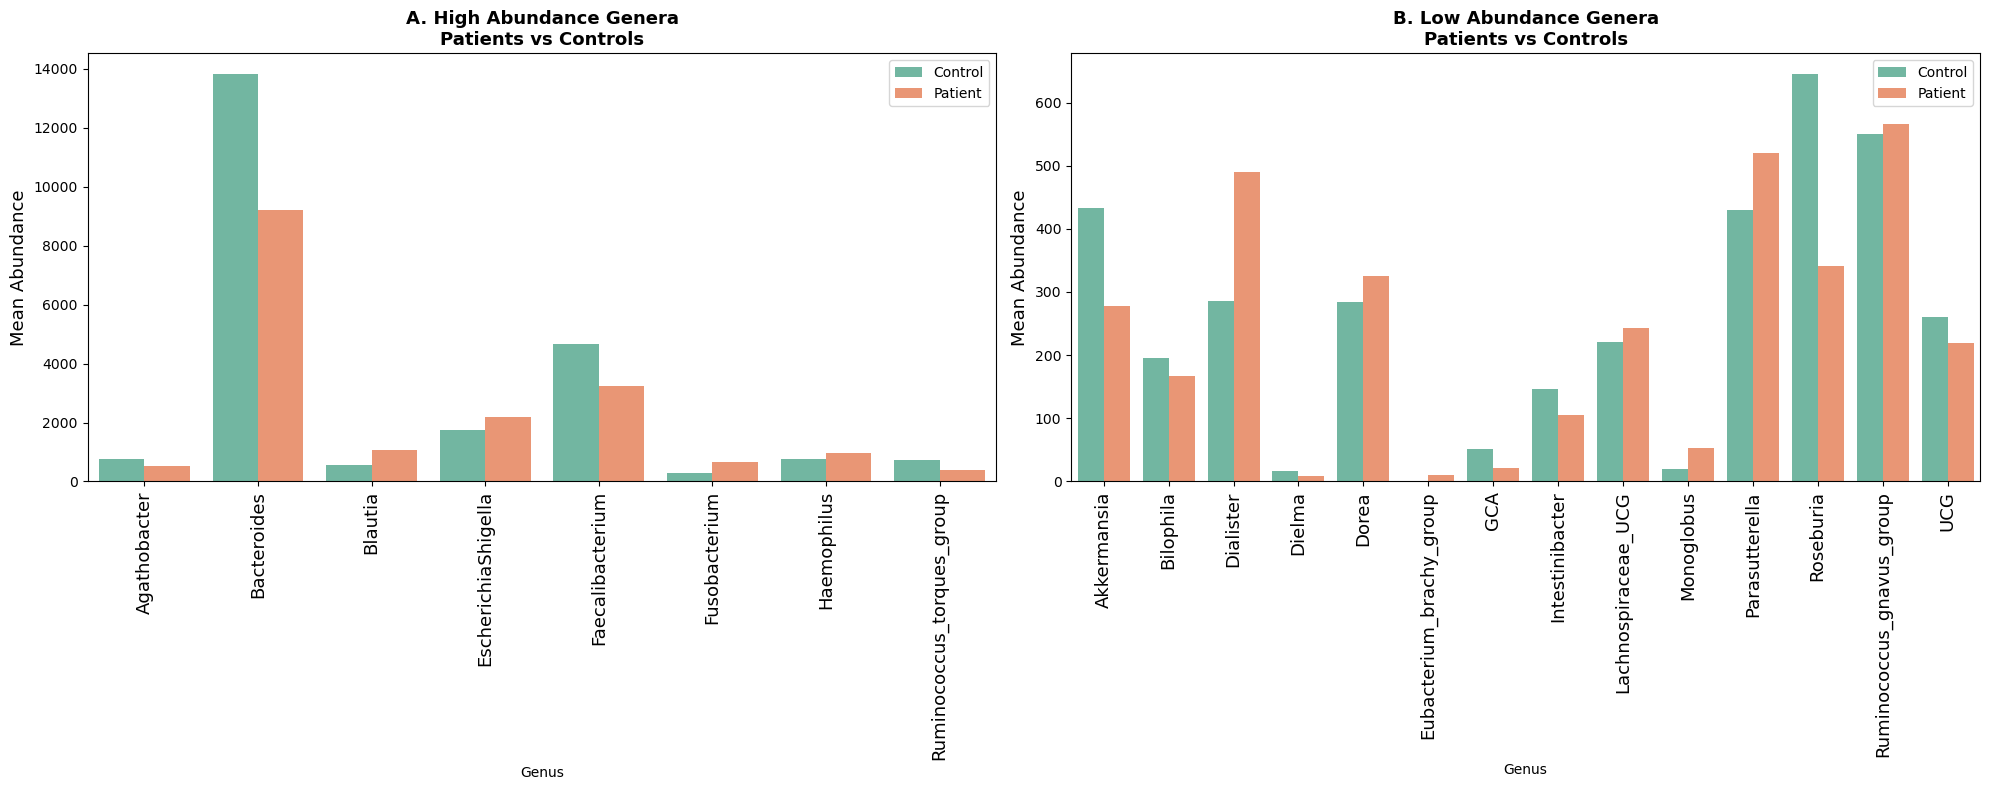

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load training data from previous step
train_df_clean = pd.read_csv("C:/Users/YLS/Documents/clean_train.csv")

# Ensure label column is treated as string
train_df_clean['label'] = train_df_clean['label'].astype(str)

# Split by class label
controls = train_df_clean[train_df_clean['label'] == '0'].drop(columns='label')
patients = train_df_clean[train_df_clean['label'] == '1'].drop(columns='label')

# Compute mean abundance per genus
control_means = controls.mean()
patient_means = patients.mean()

# Combine into a single dataframe
combined_df = pd.DataFrame({
    'Control': control_means,
    'Patient': patient_means
})

# Define high and low abundance bacteria groups (no overlap)
high_abundance_genera = [
    'Bacteroides', 'Fusobacterium', 'EscherichiaShigella', 'Faecalibacterium','Haemophilus','Blautia','Agathobacter', 'Ruminococcus_torques_group'
]

low_abundance_genera = [
    'Roseburia', 'Dorea', 'Dielma', 'Lachnospiraceae_UCG', 'UCG', 'Dialister', 'Intestinibacter', 'GCA', 'Tuzzerella' 
    'Veillonella', 'Ruminococcus_gnavus_group', 'Bilophila', 
    'Akkermansia', 'Eubacterium_brachy_group', 
    'Monoglobus', 'Parasutterella'
]

# Filter dataframes for each group
high_abundance_df = combined_df[combined_df.index.isin(high_abundance_genera)]
low_abundance_df = combined_df[combined_df.index.isin(low_abundance_genera)]

# Prepare for Seaborn plot
def prepare_plot_df(df, group_name):
    plot_df = df.reset_index().melt(id_vars='index', var_name='Group', value_name='Mean Abundance')
    plot_df.rename(columns={'index': 'Genus'}, inplace=True)
    plot_df['Abundance_Group'] = group_name
    return plot_df

high_plot_df = prepare_plot_df(high_abundance_df, 'High Abundance')
low_plot_df = prepare_plot_df(low_abundance_df, 'Low Abundance')

# Create subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot A: High abundance genera
sns.barplot(data=high_plot_df, x='Genus', y='Mean Abundance', hue='Group', palette='Set2', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90,fontsize=13)
ax1.set_title("A. High Abundance Genera\nPatients vs Controls",fontweight='bold',fontsize=13)
ax1.set_ylabel('Mean Abundance',fontsize=13)
ax1.legend()

# Plot B: Low abundance genera
sns.barplot(data=low_plot_df, x='Genus', y='Mean Abundance', hue='Group', palette='Set2', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90,fontsize=13)
ax2.set_title("B. Low Abundance Genera\nPatients vs Controls",fontweight='bold',fontsize=13)
ax2.set_ylabel('Mean Abundance',fontsize=13)
ax2.legend()

plt.tight_layout()
plt.show()



In [116]:
train_df_clean['label'] = train_df_clean['label'].astype(str)

# Get raw counts
raw_counts = train_df_clean['label'].value_counts()

print("EXACT Original Sample Counts:")
print(f"Controls (0): {raw_counts['0']} samples")
print(f"Patients (1): {raw_counts['1']} samples")
print(f"Total: {len(train_df_clean)} samples")

EXACT Original Sample Counts:
Controls (0): 269 samples
Patients (1): 759 samples
Total: 1028 samples


### Plot the data size before and after smote

Original Dataset:
label
1    759
0    269
Name: count, dtype: int64


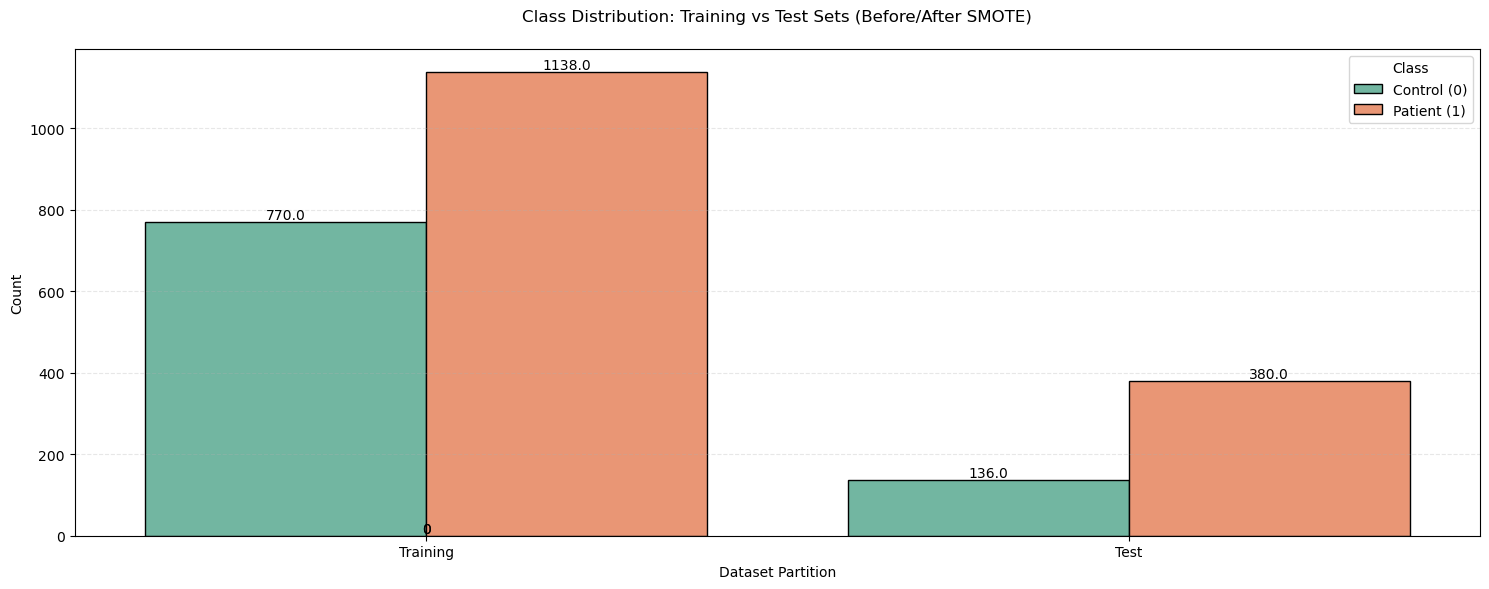


Detailed Counts:
Class              0    1
Set      SMOTE           
Test     After    68  190
         Before   68  190
Training After   569  569
         Before  201  569


In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Load your cleaned training data
train_df_clean = pd.read_csv("C:/Users/YLS/Documents/clean_train.csv")
train_df_clean['label'] = train_df_clean['label'].astype(str)  # Ensure label is string

# 1. Original Data Distribution
print("Original Dataset:")
print(train_df_clean['label'].value_counts())

# 2. Split into train/test (using your existing test size of n=258)
X = train_df_clean.drop(columns='label')
y = train_df_clean['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=258, stratify=y, random_state=42)

# 3. Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 4. Create comparison DataFrames
original_dist = pd.DataFrame({
    'Set': ['Training']*len(y_train) + ['Test']*len(y_test),
    'Class': pd.concat([y_train, y_test]),
    'SMOTE': 'Before'
})

resampled_dist = pd.DataFrame({
    'Set': ['Training']*len(y_train_res) + ['Test']*len(y_test),
    'Class': pd.concat([pd.Series(y_train_res), y_test.reset_index(drop=True)]),
    'SMOTE': 'After'
})

combined_dist = pd.concat([original_dist, resampled_dist])

# 5. Plot all distributions
plt.figure(figsize=(15, 6))
sns.countplot(data=combined_dist, x='Set', hue='Class', palette='Set2', 
             hue_order=['0', '1'], edgecolor='black', 
             order=['Training', 'Test'],
             dodge=True)

# Add annotations
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height()}", 
                      (p.get_x() + p.get_width()/2., p.get_height()), 
                      ha='center', va='center', 
                      xytext=(0, 5), textcoords='offset points')

plt.title("Class Distribution: Training vs Test Sets (Before/After SMOTE)", pad=20)
plt.xlabel("Dataset Partition")
plt.ylabel("Count")
plt.legend(title='Class', labels=['Control (0)', 'Patient (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Print exact counts
print("\nDetailed Counts:")
print(combined_dist.groupby(['Set', 'SMOTE', 'Class']).size().unstack())

## Normalizaton

In [120]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

# 1. Charger les jeux de données déjà nettoyés
train_df = pd.read_csv("C:/Users/YLS/Documents/clean_train.csv")
test_df = pd.read_csv("C:/Users/YLS/Documents/clean_test.csv")

# 2. Séparer features et labels
X_train = train_df.drop(columns='label')
y_train = train_df['label'].astype(str)

X_test = test_df.drop(columns='label')
y_test = test_df['label'].astype(str)

# 3. Normaliser les données (fit uniquement sur train)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Appliquer SMOTE sur train uniquement
print("⚖️ Applying SMOTE to balance training data...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# 5. Vérifier distribution après SMOTE
print("✅ Distribution après SMOTE :")
print(pd.Series(y_train_smote).value_counts())

# 6. Convertir en DataFrames et sauvegarder
X_train_smote_df = pd.DataFrame(X_train_smote, columns=X_train.columns)
X_train_smote_df['label'] = y_train_smote

X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_test_scaled_df['label'] = y_test

X_train_smote_df.to_csv("C:/Users/YLS/Documents/processed_train.csv", index=False)
X_test_scaled_df.to_csv("C:/Users/YLS/Documents/processed_test.csv", index=False)


⚖️ Applying SMOTE to balance training data...
✅ Distribution après SMOTE :
label
1    759
0    759
Name: count, dtype: int64


## RF

In [122]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, classification_report

def run_rf_analysis(train_features, train_labels, test_features, test_labels):
    """
    Random Forest pipeline with full parameter control, 5-fold CV, and test evaluation.
    """

    # Ensure numpy arrays
    assert isinstance(train_features, np.ndarray), "train_features should be numpy array"
    assert isinstance(test_features, np.ndarray), "test_features should be numpy array"

    print("\n🔁 Performing 5-fold cross-validation (ROC AUC)...")
    rf_cv = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    min_samples_split=4,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

    cv_scores = cross_val_score(
        rf_cv, train_features, train_labels,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='roc_auc',
        n_jobs=-1
    )

    print(f"✅ CV AUC Scores: {cv_scores}")
    print(f"✅ Mean CV AUC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

    print("\n🎯 Training final model on full training data...")
    rf_final = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    min_samples_split=4,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
    rf_final.fit(train_features, train_labels)

    print("\n📊 Evaluating on test set...")
    test_preds = rf_final.predict(test_features)
    test_probs = rf_final.predict_proba(test_features)[:, 1]

    auc = roc_auc_score(test_labels, test_probs)
    bal_acc = balanced_accuracy_score(test_labels, test_preds)

    print(f"AUC: {auc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print("\n📝 Classification Report:")
    print(classification_report(test_labels, test_preds, target_names=['0', '1']))

    return rf_final, test_preds, test_probs

# Example usage:
model_rf, preds, probs = run_rf_analysis(
    train_features=X_train_smote,
    train_labels=y_train_smote,
    test_features=X_test_scaled,
    test_labels=y_test
)



🔁 Performing 5-fold cross-validation (ROC AUC)...
✅ CV AUC Scores: [0.96186807 0.96489785 0.95377424 0.95669223 0.96876089]
✅ Mean CV AUC: 0.9612 ± 0.0054

🎯 Training final model on full training data...

📊 Evaluating on test set...
AUC: 0.8186
Balanced Accuracy: 0.7219

📝 Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.52      0.60        67
           1       0.85      0.92      0.88       191

    accuracy                           0.82       258
   macro avg       0.77      0.72      0.74       258
weighted avg       0.81      0.82      0.81       258



### RF tuning

In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, balanced_accuracy_score
import numpy as np

# Expanded hyperparameter space
param_dist = {
    'n_estimators': [300, 400, 500, 600, 700, 800],
    'max_depth': [6, 8, 10, 12, 14, None],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']  # Try both
}

# Initial model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearch with more iterations
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # More iterations for broader exploration
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
random_search.fit(X_train_smote, y_train_smote)

# Print best params and scores
print("✅ Best parameters found:")
print(random_search.best_params_)
print(f"✅ Best CV ROC AUC: {random_search.best_score_:.4f}")

# Evaluate on test set
best_model = random_search.best_estimator_
test_probs = best_model.predict_proba(X_test_scaled)[:, 1]
test_preds = best_model.predict(X_test_scaled)

# Metrics
auc = roc_auc_score(y_test, test_probs)
bal_acc = balanced_accuracy_score(y_test, test_preds)

print(f"\n🎯 Test AUC with tuned model: {auc:.4f}")
print(f"📊 Balanced Accuracy: {bal_acc:.4f}")
print("\n📝 Classification Report:")
print(classification_report(y_test, test_preds, target_names=['Control (0)', 'IBD (1)']))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
✅ Best parameters found:
{'n_estimators': 700, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': None}
✅ Best CV ROC AUC: 0.9618

🎯 Test AUC with tuned model: 0.8248
📊 Balanced Accuracy: 0.7044

📝 Classification Report:
              precision    recall  f1-score   support

 Control (0)       0.67      0.49      0.57        67
     IBD (1)       0.84      0.92      0.88       191

    accuracy                           0.81       258
   macro avg       0.76      0.70      0.72       258
weighted avg       0.79      0.81      0.80       258



### RF top 20 features

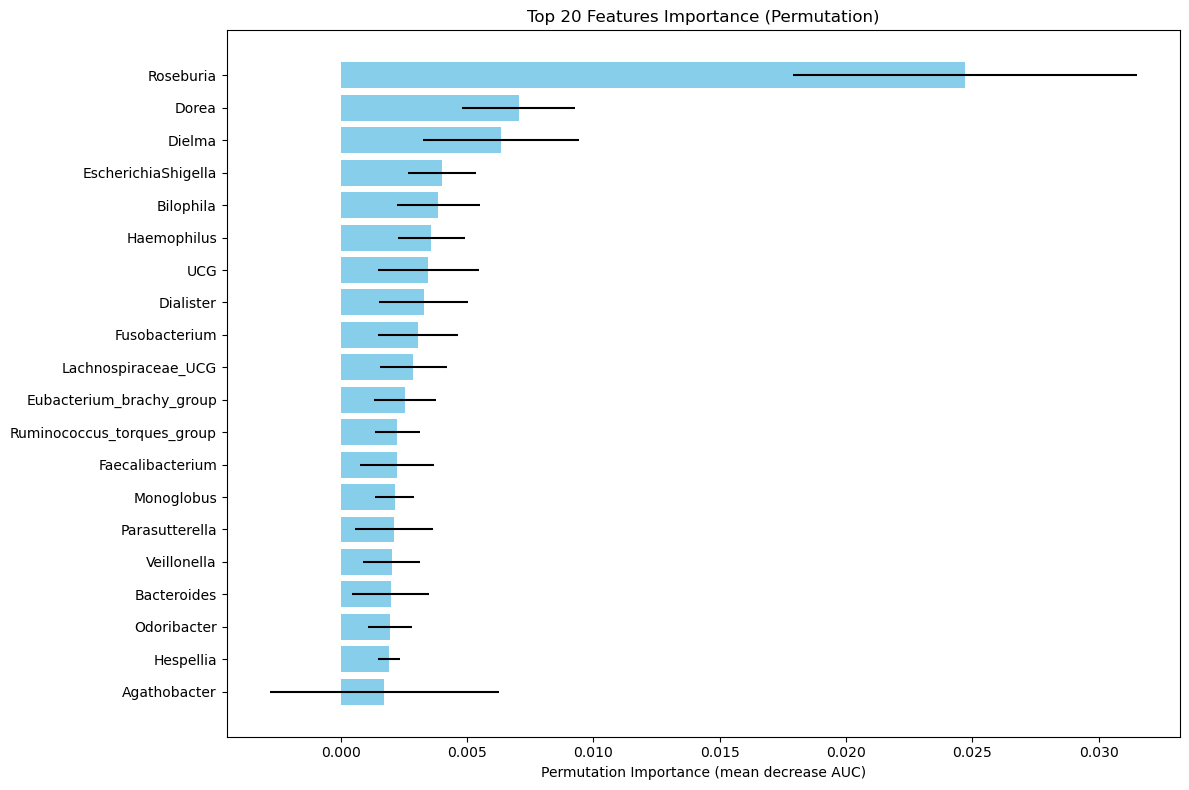


Top 15 Feature Importances (Mean ± Std Dev):
                   Feature  Importance_mean  Importance_std
                 Roseburia           0.0247          0.0068
                     Dorea           0.0070          0.0022
                    Dielma           0.0063          0.0031
       EscherichiaShigella           0.0040          0.0013
                 Bilophila           0.0039          0.0016
               Haemophilus           0.0036          0.0013
                       UCG           0.0035          0.0020
                 Dialister           0.0033          0.0018
             Fusobacterium           0.0030          0.0016
       Lachnospiraceae_UCG           0.0029          0.0013
  Eubacterium_brachy_group           0.0025          0.0012
Ruminococcus_torques_group           0.0022          0.0009
          Faecalibacterium           0.0022          0.0015
                Monoglobus           0.0021          0.0008
            Parasutterella           0.0021          0

,Feature,Importance_mean,Importance_std
619,Roseburia,0.024709,0.006793
236,Dorea,0.007041,0.002230
230,Dielma,0.006345,0.003096
262,EscherichiaShigella,0.004009,0.001339
105,Bilophila,0.003852,0.001640
...,...,...,...
268,Eubacterium_hallii_group,-0.001618,0.001030
310,Fusicatenibacter,-0.002243,0.003240
617,Romboutsia,-0.002352,0.002690
541,Phascolarctobacterium,-0.003126,0.002443


In [126]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import permutation_importance
import numpy as np

def plot_permutation_importance(model, X_test, y_test, feature_names, top_n=20):
    """
    Calcule et trace l'importance des features par permutation.
    
    Args:
        model : modèle entraîné (ex. RandomForestClassifier)
        X_test : array ou DataFrame, données test (features)
        y_test : array ou Series, labels test
        feature_names : list, noms des features
        top_n : int, nombre de features à afficher (par défaut 20)
        
    Returns:
        DataFrame trié des importances
    """
    # Calcul de l'importance par permutation (plus long mais fiable)
    result = permutation_importance(model, X_test, y_test, 
                                  n_repeats=10, 
                                  random_state=42, 
                                  scoring='roc_auc', 
                                  n_jobs=1)

    # Création DataFrame pour tri
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance_mean': result.importances_mean,  # Renommé pour cohérence
        'Importance_std': result.importances_std     # Renommé pour cohérence
    }).sort_values(by='Importance_mean', ascending=False)

    # Plot avec barres d'erreur (écart-type)
    top_features = importance_df.head(top_n)
    plt.figure(figsize=(12, 8))
    plt.barh(top_features['Feature'][::-1], 
             top_features['Importance_mean'][::-1], 
             xerr=top_features['Importance_std'][::-1], 
             color='skyblue')
    plt.xlabel('Permutation Importance (mean decrease AUC)')
    plt.title(f'Top {top_n} Features Importance (Permutation)')
    plt.tight_layout()
    plt.show()

    # Affichage des 15 features les plus importantes
    print("\nTop 15 Feature Importances (Mean ± Std Dev):")
    print(importance_df[['Feature', 'Importance_mean', 'Importance_std']]
          .head(15)
          .to_string(index=False, float_format="%.4f"))
    
    return importance_df

# Exemple d'utilisation avec ton modèle et données test
plot_permutation_importance(
    model=model_rf,
    X_test=X_test_scaled,
    y_test=y_test,
    feature_names=X_test.columns,
    top_n=20
)

## XGBoost

In [22]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [28]:
pip show xgboost


Name: xgboost
Version: 3.0.2
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: C:\Users\YLS\anaconda3\Lib\site-packages
Requires: numpy, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [62]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, classification_report

def run_xgb_analysis(train_features, train_labels, test_features, test_labels):
    """
    XGBoost pipeline with 5-fold CV (ROC AUC), final model training, and test evaluation.
    """

    # Ensure numpy arrays
    assert isinstance(train_features, np.ndarray), "train_features should be numpy array"
    assert isinstance(test_features, np.ndarray), "test_features should be numpy array"

    print("\n🔁 Performing 5-fold cross-validation (ROC AUC)...")
    xgb_cv = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.6,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)


    cv_scores = cross_val_score(
        xgb_cv, train_features, train_labels,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='roc_auc',
        n_jobs=-1
    )

    print(f"✅ CV AUC Scores: {cv_scores}")
    print(f"✅ Mean CV AUC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

    print("\n🎯 Training final model on full training data...")
    xgb_final = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.6,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

    xgb_final.fit(train_features, train_labels)

    print("\n📊 Evaluating on test set...")
    test_preds = xgb_final.predict(test_features)
    test_probs = xgb_final.predict_proba(test_features)[:, 1]

    auc = roc_auc_score(test_labels, test_probs)
    bal_acc = balanced_accuracy_score(test_labels, test_preds)

    print(f"AUC: {auc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print("\n📝 Classification Report:")
    print(classification_report(test_labels, test_preds, target_names=['class 0', 'class 1']))

    return xgb_final, test_preds, test_probs
y_train_smote = y_train_smote.astype(int)
y_test = y_test.astype(int)

# Run it
model_xgb, preds, probs = run_xgb_analysis(
    train_features=X_train_smote,
    train_labels=y_train_smote,
    test_features=X_test_scaled,
    test_labels=y_test
)




🔁 Performing 5-fold cross-validation (ROC AUC)...
✅ CV AUC Scores: [0.95766967 0.9568473  0.96251731 0.96348902 0.9717236 ]
✅ Mean CV AUC: 0.9624 ± 0.0053

🎯 Training final model on full training data...

📊 Evaluating on test set...
AUC: 0.8475
Balanced Accuracy: 0.7365

📝 Classification Report:
              precision    recall  f1-score   support

     class 0       0.68      0.57      0.62        67
     class 1       0.86      0.91      0.88       191

    accuracy                           0.82       258
   macro avg       0.77      0.74      0.75       258
weighted avg       0.81      0.82      0.81       258




### Tuning XGBoost

In [45]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Définir l’estimateur de base
xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

# Dictionnaire des hyperparamètres à explorer
param_distributions = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2],
    'scale_pos_weight': [1, 2, 3]  # utile pour les classes déséquilibrées
}

# Validation croisée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=30,  # tu peux augmenter selon ta puissance
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)
y_train = y_train.astype(int)

# Ajustement du modèle (X_train, y_train déjà préparés)
random_search.fit(X_train, y_train)

# Meilleurs paramètres
print("✅ Meilleurs paramètres XGBoost :")
print(random_search.best_params_)

# Meilleur estimateur
best_xgb_model = random_search.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\YLS\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:26:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Meilleurs paramètres XGBoost :
{'subsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}


### Top 20 for XGBoost

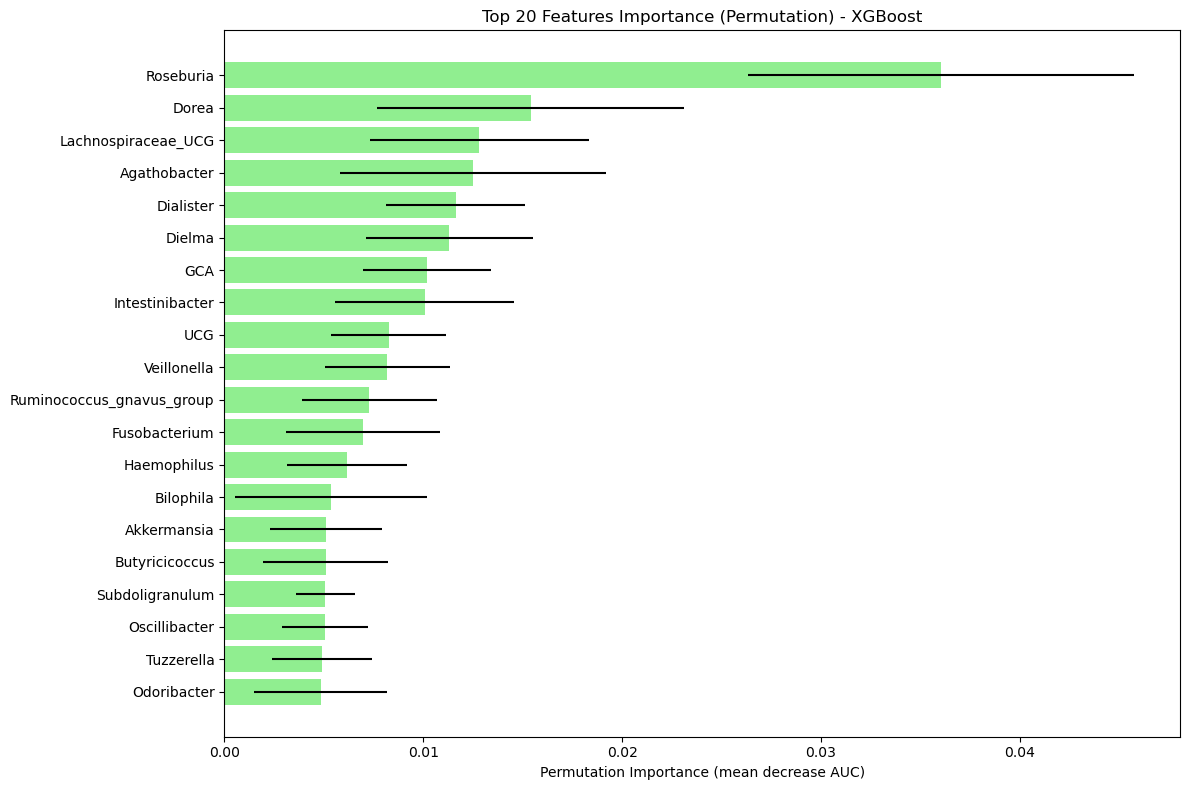


Top 15 Feature Importances (Mean ± Std Dev):
                  Feature  Importance_mean  Importance_std
                Roseburia           0.0360          0.0097
                    Dorea           0.0154          0.0077
      Lachnospiraceae_UCG           0.0128          0.0055
             Agathobacter           0.0125          0.0067
                Dialister           0.0116          0.0035
                   Dielma           0.0113          0.0042
                      GCA           0.0102          0.0032
          Intestinibacter           0.0101          0.0045
                      UCG           0.0083          0.0029
              Veillonella           0.0082          0.0031
Ruminococcus_gnavus_group           0.0073          0.0034
            Fusobacterium           0.0070          0.0039
              Haemophilus           0.0062          0.0030
                Bilophila           0.0054          0.0048
              Akkermansia           0.0051          0.0028


,Feature,Importance_mean,Importance_std
619,Roseburia,0.036032,0.009724
236,Dorea,0.015406,0.007722
390,Lachnospiraceae_UCG,0.012819,0.005503
33,Agathobacter,0.012511,0.006681
228,Dialister,0.011636,0.003499
...,...,...,...
382,Lachnoclostridium,-0.001117,0.001476
310,Fusicatenibacter,-0.001219,0.002809
44,Alistipes,-0.001453,0.001314
360,Incertae_Sedis,-0.002004,0.001359


In [265]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import permutation_importance
import numpy as np

def plot_permutation_importance_xgb(model, X_test, y_test, feature_names, top_n=20):
    """
    Calcule et trace l'importance des features par permutation pour un modèle XGBoost.
    
    Args:
        model : modèle XGBClassifier entraîné
        X_test : DataFrame ou array, features test
        y_test : array ou Series, labels test
        feature_names : list, noms des features (colonnes)
        top_n : int, nombre de features à afficher (par défaut 20)
        
    Returns:
        DataFrame trié des importances
    """
    # Workaround for XGBoost compatibility
    if not hasattr(model, 'predict_proba'):
        model.predict_proba = lambda X: model.predict(X, output_margin=False)
    
    # Calcul de l'importance par permutation (score AUC)
    result = permutation_importance(model, X_test, y_test,
                                  n_repeats=10,
                                  random_state=42,
                                  scoring='roc_auc',
                                  n_jobs=1)  # Reduced to 1 to avoid parallel issues

    # DataFrame importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance_mean': result.importances_mean,
        'Importance_std': result.importances_std
    }).sort_values(by='Importance_mean', ascending=False)

    # Plot horizontal (inverse pour top = en haut)
    top_features = importance_df.head(top_n)
    plt.figure(figsize=(12, 8))
    plt.barh(top_features['Feature'][::-1],
             top_features['Importance_mean'][::-1],
             xerr=top_features['Importance_std'][::-1],
             color='lightgreen')
    plt.xlabel('Permutation Importance (mean decrease AUC)')
    plt.title(f'Top {top_n} Features Importance (Permutation) - XGBoost')
    plt.tight_layout()
    plt.show()

    # Affichage des 15 features les plus importantes
    print("\nTop 15 Feature Importances (Mean ± Std Dev):")
    print(importance_df[['Feature', 'Importance_mean', 'Importance_std']]
          .head(15)
          .to_string(index=False, float_format="%.4f"))
    
    return importance_df

# Exemple d'utilisation (à adapter selon ton jeu de données et modèle)
plot_permutation_importance_xgb(
    model=model_xgb,             # ton modèle xgboost entraîné
    X_test=X_test_scaled,        # tes données test (features)
    y_test=y_test,               # tes labels test (int)
    feature_names=X_test.columns,# noms des features
    top_n=20
)

## LightGBM

In [79]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, classification_report

def run_lgbm_analysis(train_features, train_labels, test_features, test_labels):
    """
    Pipeline LightGBM avec CV 5-fold (AUC ROC), entraînement final, et évaluation test.
    """

    # Vérification numpy arrays
    assert isinstance(train_features, np.ndarray), "train_features doit être un numpy array"
    assert isinstance(test_features, np.ndarray), "test_features doit être un numpy array"

    print("\n🔁 Cross-validation 5-fold (ROC AUC)...")
    lgbm_clf = lgb.LGBMClassifier(
        n_estimators=700,
        max_depth=8,
        learning_rate=0.07999,
        subsample=0.9,
        colsample_bytree=1,
        random_state=42,
        n_jobs=-1
    )

    cv_scores = cross_val_score(
        lgbm_clf,
        train_features,
        train_labels,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='roc_auc',
        n_jobs=-1
    )

    print(f"✅ Scores CV AUC: {cv_scores}")
    print(f"✅ Moyenne CV AUC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

    print("\n🎯 Entraînement du modèle final sur toutes les données d'entraînement...")
    lgbm_final = lgb.LGBMClassifier(
        n_estimators=700,
        max_depth=8,
        learning_rate=0.07999,
        subsample=0.9,
        colsample_bytree=1,
        random_state=42,
        n_jobs=-1
    )

    lgbm_final.fit(train_features, train_labels)

    print("\n📊 Évaluation sur le jeu de test...")
    test_preds = lgbm_final.predict(test_features)
    test_probs = lgbm_final.predict_proba(test_features)[:, 1]

    auc = roc_auc_score(test_labels, test_probs)
    bal_acc = balanced_accuracy_score(test_labels, test_preds)

    print(f"AUC test: {auc:.4f}")
    print(f"Balanced Accuracy test: {bal_acc:.4f}")
    print("\n📝 Rapport de classification :")
    print(classification_report(test_labels, test_preds, target_names=['class 0', 'class 1']))

    return lgbm_final, test_preds, test_probs

# Assure-toi que les labels sont bien des entiers
y_train_smote = y_train_smote.astype(int)
y_test = y_test.astype(int)

# Exécution de l'analyse LightGBM
model_lgbm, preds_lgbm, probs_lgbm = run_lgbm_analysis(
    train_features=X_train_smote,
    train_labels=y_train_smote,
    test_features=X_test_scaled,
    test_labels=y_test
)



🔁 Cross-validation 5-fold (ROC AUC)...
✅ Scores CV AUC: [0.96818733 0.96485457 0.9652874  0.97307424 0.97181074]
✅ Moyenne CV AUC: 0.9686 ± 0.0033

🎯 Entraînement du modèle final sur toutes les données d'entraînement...
[LightGBM] [Info] Number of positive: 759, number of negative: 759
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24228
[LightGBM] [Info] Number of data points in the train set: 1518, number of used features: 262
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

C:\Users\YLS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\YLS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Tuning LightGBM

In [71]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Définition du classifieur LightGBM de base
lgbm = lgb.LGBMClassifier(random_state=42, n_jobs=-1)

# Grille de recherche pour RandomizedSearchCV
param_dist = {
    'num_leaves': np.arange(20, 150, 10),           # nombre de feuilles dans l'arbre
    'max_depth': np.arange(3, 15, 1),               # profondeur max de l'arbre
    'learning_rate': np.linspace(0.01, 0.3, 30),   # taux d'apprentissage
    'n_estimators': np.arange(100, 1000, 100),      # nombre d'arbres
    'subsample': np.linspace(0.5, 1.0, 6),          # échantillonnage des échantillons (bagging)
    'colsample_bytree': np.linspace(0.4, 1.0, 7),   # échantillonnage des features
    'reg_alpha': np.linspace(0, 1.0, 11),            # régularisation L1
    'reg_lambda': np.linspace(0, 1.0, 11)            # régularisation L2
}

# Stratified K-Fold CV pour classification binaire
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=50,                    # nombre d'itérations (param combos testés)
    scoring='roc_auc',            # critère d'optimisation
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    refit=True
)

# Assure-toi que tes labels sont bien des int
y_train_smote = y_train_smote.astype(int)

# Lancement de la recherche
random_search.fit(X_train_smote, y_train_smote)

# Affichage des meilleurs paramètres et score
print("✅ Meilleurs paramètres LightGBM :")
print(random_search.best_params_)
print(f"✅ Meilleur score CV AUC : {random_search.best_score_:.4f}")

# Le meilleur modèle est accessible par
best_lgbm_model = random_search.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 759, number of negative: 759
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24228
[LightGBM] [Info] Number of data points in the train set: 1518, number of used features: 262
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

### Top 20 features LightGBM

C:\Users\YLS\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


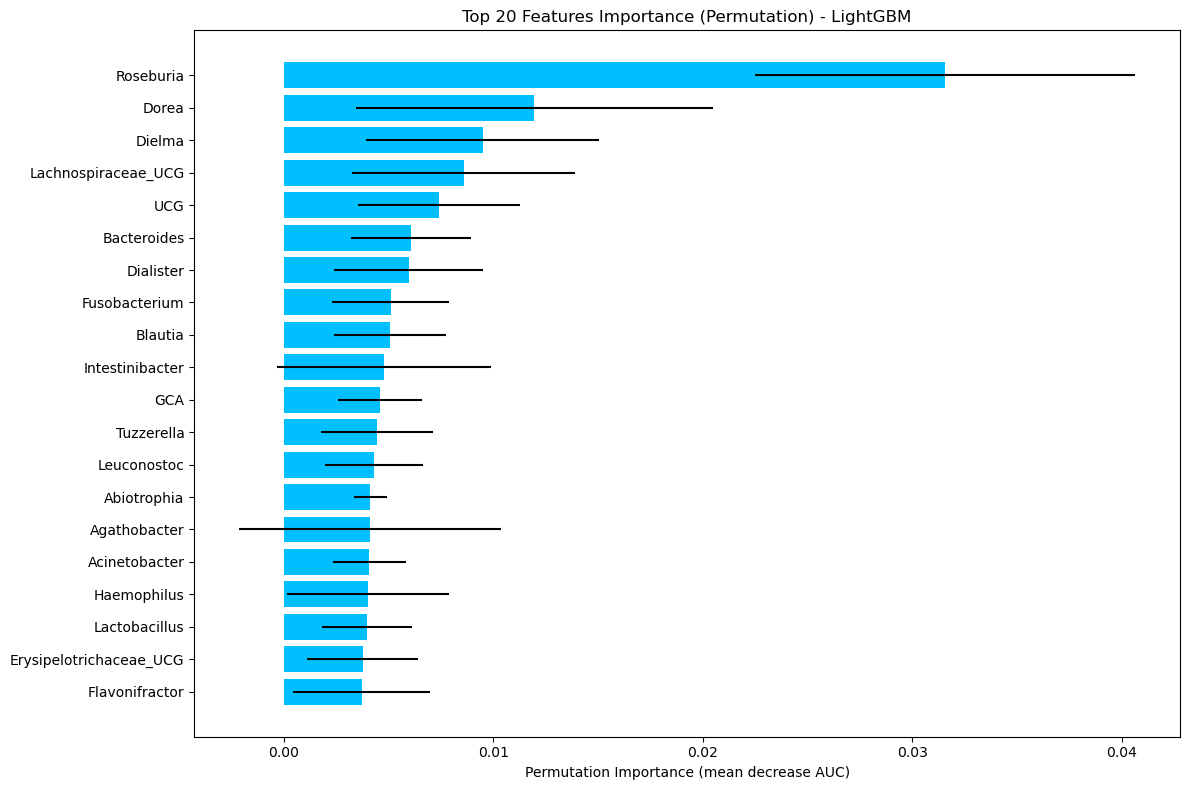


Top 15 Feature Importances (Mean ± Std Dev):
            Feature  Importance_mean  Importance_std
          Roseburia           0.0316          0.0091
              Dorea           0.0120          0.0085
             Dielma           0.0095          0.0056
Lachnospiraceae_UCG           0.0086          0.0053
                UCG           0.0074          0.0039
        Bacteroides           0.0061          0.0029
          Dialister           0.0060          0.0035
      Fusobacterium           0.0051          0.0028
            Blautia           0.0051          0.0027
    Intestinibacter           0.0048          0.0051
                GCA           0.0046          0.0020
         Tuzzerella           0.0044          0.0027
        Leuconostoc           0.0043          0.0023
        Abiotrophia           0.0041          0.0008
       Agathobacter           0.0041          0.0063


,Feature,Importance_mean,Importance_std
619,Roseburia,0.031554,0.009086
236,Dorea,0.011956,0.008510
230,Dielma,0.009494,0.005558
390,Lachnospiraceae_UCG,0.008580,0.005311
732,UCG,0.007385,0.003866
...,...,...,...
318,Gemella,-0.001860,0.004117
104,Bifidobacterium,-0.002891,0.001819
382,Lachnoclostridium,-0.003118,0.001430
383,Lachnospira,-0.003321,0.001958


In [255]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import permutation_importance
import numpy as np

def plot_permutation_importance_lgbm(model, X_test, y_test, feature_names, top_n=20):
    """
    Calcule et trace l'importance des features par permutation pour LightGBM.
    
    Args:
        model : modèle LightGBM entraîné
        X_test : numpy array ou DataFrame, features test
        y_test : labels test
        feature_names : list, noms des features (obligatoire, sinon erreur)
        top_n : nombre de features à afficher
        
    Returns:
        DataFrame trié des importances
    """
    if feature_names is None:
        raise ValueError("feature_names must be provided as a list of feature names.")

    # Calcul de l'importance par permutation
    result = permutation_importance(
        model, X_test, y_test,
        n_repeats=10,
        random_state=42,
        scoring='roc_auc',
        n_jobs=-1
    )

    # Création du DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance_mean': result.importances_mean,  # Renommé pour cohérence
        'Importance_std': result.importances_std     # Renommé pour cohérence
    }).sort_values(by='Importance_mean', ascending=False)

    # Visualisation (top_n features)
    top_features = importance_df.head(top_n)
    plt.figure(figsize=(12, 8))
    plt.barh(
        top_features['Feature'][::-1],
        top_features['Importance_mean'][::-1],
        xerr=top_features['Importance_std'][::-1],
        color='deepskyblue'
    )
    plt.xlabel('Permutation Importance (mean decrease AUC)')
    plt.title(f'Top {top_n} Features Importance (Permutation) - LightGBM')
    plt.tight_layout()
    plt.show()

    # Affichage des 15 features les plus importantes
    print("\nTop 15 Feature Importances (Mean ± Std Dev):")
    print(importance_df[['Feature', 'Importance_mean', 'Importance_std']]
          .head(15)
          .to_string(index=False, float_format="%.4f"))
    
    return importance_df


# Exemple d'utilisation avec tes variables LightGBM
feature_names = X_test.columns.tolist()  # Récupère les noms des colonnes AVANT transformation

plot_permutation_importance_lgbm(
    model=best_lgbm_model,
    X_test=X_test_scaled,  # numpy array
    y_test=y_test,
    feature_names=feature_names,  # liste explicite, obligatoire
    top_n=20
)

## CatBoost

In [95]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, classification_report
import numpy as np

def run_catboost_analysis(train_features, train_labels, test_features, test_labels):
    """
    CatBoost pipeline with 5-fold CV (ROC AUC), final model training, and test evaluation.
    """
    print("\n🔁 Performing 5-fold cross-validation (ROC AUC)...")

    catboost_model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.01,
        depth=6,
        eval_metric='AUC',
        verbose=0,
        random_seed=42
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(
        catboost_model, train_features, train_labels,
        cv=cv, scoring='roc_auc', n_jobs=-1
    )

    print(f"✅ CV AUC Scores: {cv_scores}")
    print(f"✅ Mean CV AUC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

    print("\n🎯 Training final model on full training data...")
    catboost_model.fit(train_features, train_labels, verbose=0)

    print("\n📊 Evaluating on test set...")
    test_preds = catboost_model.predict(test_features)
    test_probs = catboost_model.predict_proba(test_features)[:, 1]

    auc = roc_auc_score(test_labels, test_probs)
    bal_acc = balanced_accuracy_score(test_labels, test_preds)

    print(f"AUC: {auc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print("\n📝 Classification Report:")
    print(classification_report(test_labels, test_preds, target_names=['class 0', 'class 1']))

    return catboost_model, test_preds, test_probs
# Assure-toi que y_train_smote et y_test sont bien en entier
y_train_smote = y_train_smote.astype(int)
y_test = y_test.astype(int)

# Entraînement + évaluation
model_catboost, preds_cat, probs_cat = run_catboost_analysis(
    train_features=X_train_smote,
    train_labels=y_train_smote,
    test_features=X_test_scaled,
    test_labels=y_test
)



🔁 Performing 5-fold cross-validation (ROC AUC)...
✅ CV AUC Scores: [0.94775796 0.9409626  0.93901489 0.9423144  0.96113628]
✅ Mean CV AUC: 0.9462 ± 0.0080

🎯 Training final model on full training data...

📊 Evaluating on test set...
AUC: 0.8214
Balanced Accuracy: 0.6935

📝 Classification Report:
              precision    recall  f1-score   support

     class 0       0.60      0.51      0.55        67
     class 1       0.84      0.88      0.86       191

    accuracy                           0.78       258
   macro avg       0.72      0.69      0.70       258
weighted avg       0.77      0.78      0.78       258



### Top 20 Catboost

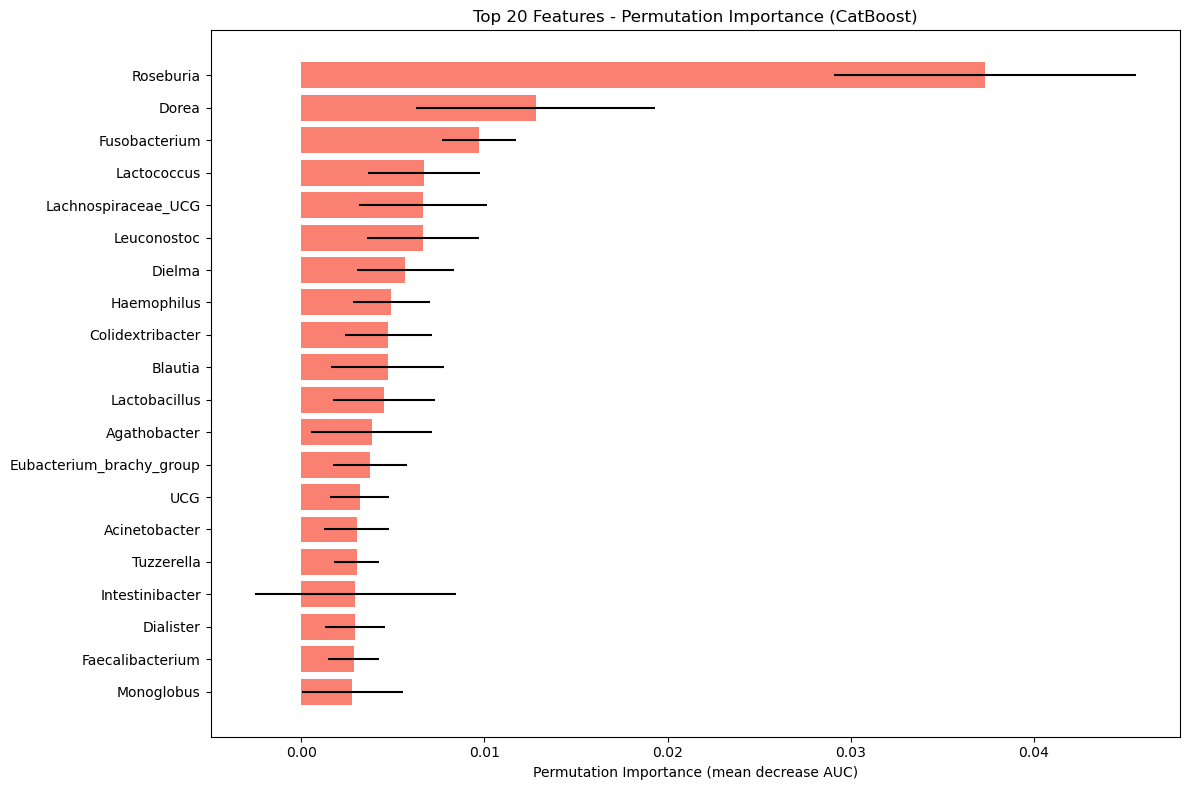


Top 15 Feature Importances (Mean ± Std Dev):
                 Feature  Importance_mean  Importance_std
               Roseburia           0.0373          0.0082
                   Dorea           0.0128          0.0065
           Fusobacterium           0.0097          0.0020
             Lactococcus           0.0067          0.0031
     Lachnospiraceae_UCG           0.0066          0.0035
             Leuconostoc           0.0066          0.0031
                  Dielma           0.0057          0.0027
             Haemophilus           0.0049          0.0021
        Colidextribacter           0.0048          0.0024
                 Blautia           0.0047          0.0031
           Lactobacillus           0.0045          0.0028
            Agathobacter           0.0038          0.0033
Eubacterium_brachy_group           0.0037          0.0020
                     UCG           0.0032          0.0016
           Acinetobacter           0.0030          0.0018


,Feature,Importance_mean,Importance_std
619,Roseburia,0.037345,0.008239
236,Dorea,0.012792,0.006531
311,Fusobacterium,0.009698,0.002032
395,Lactococcus,0.006713,0.003067
390,Lachnospiraceae_UCG,0.006650,0.003481
...,...,...,...
310,Fusicatenibacter,-0.001532,0.002537
541,Phascolarctobacterium,-0.001625,0.004552
259,Erysipelatoclostridium,-0.001789,0.001401
562,Prevotella_,-0.002086,0.002198


In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

def plot_permutation_importance_catboost(model, X_test, y_test, feature_names, top_n=20):
    """
    Affiche les top_n features les plus importantes via permutation importance pour un modèle CatBoost.

    Args:
        model : modèle CatBoost entraîné
        X_test : données de test (numpy array)
        y_test : labels test (array-like)
        feature_names : liste des noms des features
        top_n : nombre de features à afficher (default 20)
        
    Returns:
        DataFrame trié des importances
    """
    if not isinstance(feature_names, list) or len(feature_names) != X_test.shape[1]:
        raise ValueError("feature_names must be a list with length equal to number of features in X_test.")

    # Importance par permutation
    result = permutation_importance(
        model, X_test, y_test,
        n_repeats=10,
        scoring='roc_auc',
        random_state=42,
        n_jobs=-1
    )

    # DataFrame des importances
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance_mean': result.importances_mean,  # Changed for consistency
        'Importance_std': result.importances_std     # Changed for consistency
    }).sort_values(by='Importance_mean', ascending=False)

    # Plot (top_n features)
    top_features = importance_df.head(top_n)
    plt.figure(figsize=(12, 8))
    plt.barh(
        top_features['Feature'][::-1],
        top_features['Importance_mean'][::-1],
        xerr=top_features['Importance_std'][::-1],
        color='salmon'
    )
    plt.xlabel('Permutation Importance (mean decrease AUC)')
    plt.title(f'Top {top_n} Features - Permutation Importance (CatBoost)')
    plt.tight_layout()
    plt.show()

    # Print top 15 features
    print("\nTop 15 Feature Importances (Mean ± Std Dev):")
    print(importance_df[['Feature', 'Importance_mean', 'Importance_std']]
          .head(15)
          .to_string(index=False, float_format="%.4f"))
    
    return importance_df

# Exemple d'utilisation
plot_permutation_importance_catboost(
    model=model_catboost,             # ton modèle entraîné
    X_test=X_test_scaled,             # ndarray
    y_test=y_test,                    # ndarray ou Series
    feature_names=feature_names,      # liste des noms de colonnes
    top_n=20
)

## SVM

In [98]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, classification_report

def run_svm_analysis(train_features, train_labels, test_features, test_labels):
    """
    Pipeline SVM avec 5-fold CV (ROC AUC), entraînement final et évaluation.
    """

    # Vérifications
    assert isinstance(train_features, np.ndarray), "train_features doit être un numpy array"
    assert isinstance(test_features, np.ndarray), "test_features doit être un numpy array"

    print("\n🔁 5-fold Cross-validation (ROC AUC) avec SVM...")

    svm_model = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        probability=True,   # Pour pouvoir utiliser predict_proba
        random_state=42
    )

    cv_scores = cross_val_score(
        svm_model,
        train_features,
        train_labels,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='roc_auc',
        n_jobs=-1
    )

    print(f"✅ AUC CV scores : {cv_scores}")
    print(f"✅ Moyenne AUC CV : {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

    print("\n🎯 Entraînement sur tout le training set...")
    svm_model.fit(train_features, train_labels)

    print("\n📊 Évaluation sur le test set...")
    test_preds = svm_model.predict(test_features)
    test_probs = svm_model.predict_proba(test_features)[:, 1]

    auc = roc_auc_score(test_labels, test_probs)
    bal_acc = balanced_accuracy_score(test_labels, test_preds)

    print(f"AUC: {auc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print("\n📝 Classification Report:")
    print(classification_report(test_labels, test_preds, target_names=['Class 0', 'Class 1']))

    return svm_model, test_preds, test_probs
y_train_smote = y_train_smote.astype(int)
y_test = y_test.astype(int)

model_svm, preds_svm, probs_svm = run_svm_analysis(
    train_features=X_train_smote,
    train_labels=y_train_smote,
    test_features=X_test_scaled,
    test_labels=y_test
)



🔁 5-fold Cross-validation (ROC AUC) avec SVM...
✅ AUC CV scores : [0.87616863 0.89079813 0.89084141 0.89077205 0.89399617]
✅ Moyenne AUC CV : 0.8885 ± 0.0063

🎯 Entraînement sur tout le training set...

📊 Évaluation sur le test set...
AUC: 0.7462
Balanced Accuracy: 0.6890

📝 Classification Report:
              precision    recall  f1-score   support

     Class 0       0.50      0.58      0.54        67
     Class 1       0.84      0.80      0.82       191

    accuracy                           0.74       258
   macro avg       0.67      0.69      0.68       258
weighted avg       0.75      0.74      0.75       258



### Top 20 from SVM

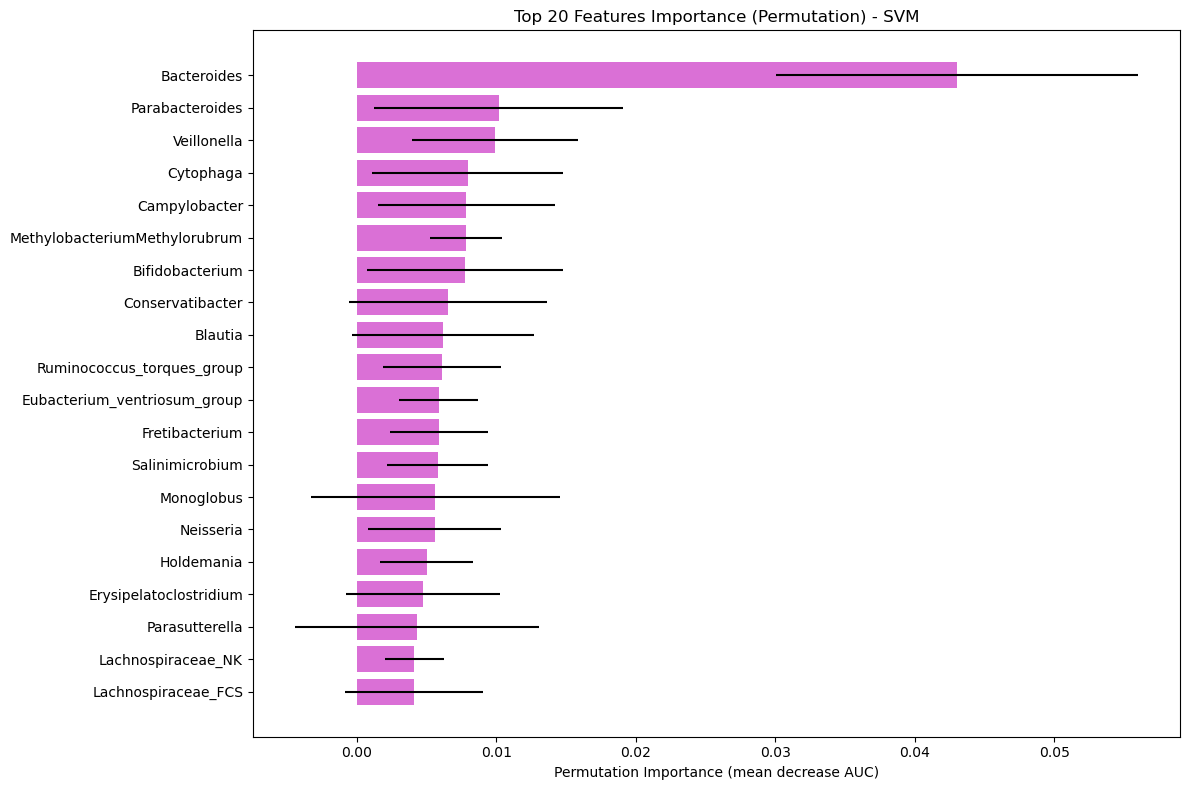


Top 15 Feature Importances (Mean ± Std Dev):
                      Feature  Importance_mean  Importance_std
                  Bacteroides           0.0430          0.0130
              Parabacteroides           0.0102          0.0089
                  Veillonella           0.0099          0.0059
                    Cytophaga           0.0079          0.0068
                Campylobacter           0.0079          0.0064
MethylobacteriumMethylorubrum           0.0078          0.0026
              Bifidobacterium           0.0077          0.0070
             Conservatibacter           0.0065          0.0071
                      Blautia           0.0062          0.0065
   Ruminococcus_torques_group           0.0061          0.0042
 Eubacterium_ventriosum_group           0.0059          0.0028
               Fretibacterium           0.0059          0.0035
              Salinimicrobium           0.0058          0.0036
                   Monoglobus           0.0056          0.0089
         

In [251]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance

def plot_permutation_importance_svm(model, X_test, y_test, feature_names, top_n=20):
    """
    Calcule et trace l'importance des features par permutation pour un modèle SVM.
    
    Args:
        model : SVC entraîné (avec probability=True)
        X_test : array ou DataFrame, données test
        y_test : array, labels test
        feature_names : list, noms des features
        top_n : nombre de features à afficher
        
    Returns:
        DataFrame trié des importances
    """
    # Vérification
    if isinstance(X_test, np.ndarray) and isinstance(feature_names, list):
        assert X_test.shape[1] == len(feature_names), "Feature names length must match X_test.shape[1]"

    # Importance par permutation
    result = permutation_importance(
        model, X_test, y_test,
        n_repeats=10,
        random_state=42,
        scoring='roc_auc',
        n_jobs=-1
    )

    # DataFrame trié
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance_mean': result.importances_mean,  # Renommé pour cohérence
        'Importance_std': result.importances_std    # Renommé pour cohérence
    }).sort_values(by='Importance_mean', ascending=False)

    # Affichage graphique (top_n features)
    top_features = importance_df.head(top_n)
    plt.figure(figsize=(12, 8))
    plt.barh(top_features['Feature'][::-1],
             top_features['Importance_mean'][::-1],
             xerr=top_features['Importance_std'][::-1],
             color='orchid')
    plt.xlabel('Permutation Importance (mean decrease AUC)')
    plt.title(f'Top {top_n} Features Importance (Permutation) - SVM')
    plt.tight_layout()
    plt.show()

    # Affichage texte (top 15 features)
    print("\nTop 15 Feature Importances (Mean ± Std Dev):")
    print(importance_df[['Feature', 'Importance_mean', 'Importance_std']]
          .head(15)
          .to_string(index=False, float_format="%.4f"))
    
    return importance_df

# Exemple d'utilisation
top_svm_features = plot_permutation_importance_svm(
    model=model_svm,
    X_test=X_test_scaled,         # ton X après scaling (numpy array)
    y_test=y_test,                # tes labels
    feature_names=feature_names,  # noms extraits du DataFrame original
    top_n=20                      # affichera 20 features dans le graphique
)

## KNN

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, classification_report
from sklearn.inspection import permutation_importance

# Step 1 — Train + Evaluate
def run_knn(train_features, train_labels, test_features, test_labels, n_neighbors=5):
    """
    Train and evaluate KNN model.
    """
    model_knn = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1)

    print("🔁 5-fold CV (ROC AUC)...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model_knn, train_features, train_labels, cv=cv, scoring='roc_auc')
    print(f"✅ CV AUC scores: {cv_scores}")
    print(f"✅ Mean CV AUC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

    print("📊 Training final model...")
    model_knn.fit(train_features, train_labels)

    test_preds = model_knn.predict(test_features)
    test_probs = model_knn.predict_proba(test_features)[:, 1]

    auc = roc_auc_score(test_labels, test_probs)
    bal_acc = balanced_accuracy_score(test_labels, test_preds)

    print(f"🎯 Test AUC: {auc:.4f}")
    print(f"🎯 Test Balanced Accuracy: {bal_acc:.4f}")
    print("\n📝 Classification Report:")
    print(classification_report(test_labels, test_preds))

    return model_knn
# Train and evaluate KNN
model_knn = run_knn(
    train_features=X_train_smote,
    train_labels=y_train_smote,
    test_features=X_test_scaled,
    test_labels=y_test,
    n_neighbors=5  # can be tuned
)

🔁 5-fold CV (ROC AUC)...
✅ CV AUC scores: [0.84608726 0.87489179 0.81765062 0.83467672 0.77306988]
✅ Mean CV AUC: 0.8293 ± 0.0337
📊 Training final model...
🎯 Test AUC: 0.6558
🎯 Test Balanced Accuracy: 0.6256

📝 Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.70      0.47        67
           1       0.84      0.55      0.66       191

    accuracy                           0.59       258
   macro avg       0.60      0.63      0.57       258
weighted avg       0.71      0.59      0.61       258



### Top 20 for KNN

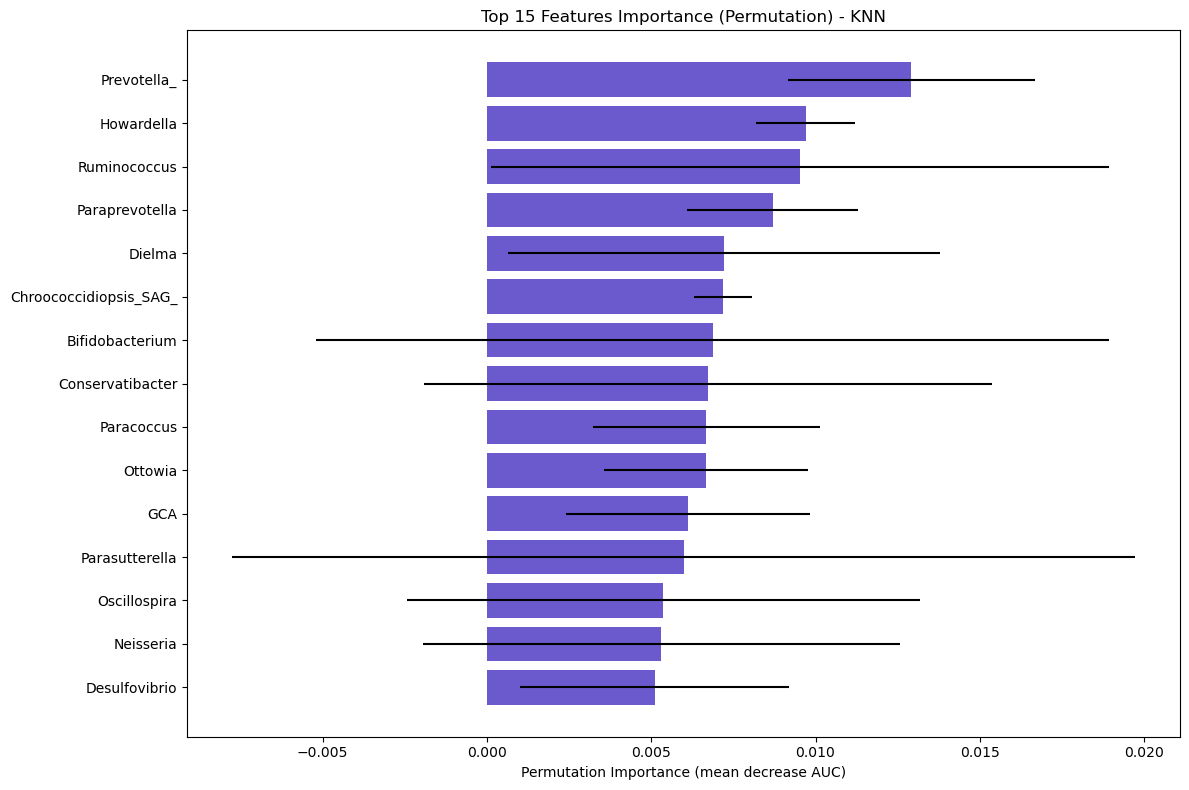


Top 15 Feature Importances (Mean ± Std Dev):
               Feature  Importance_mean  Importance_std
           Prevotella_         0.012917        0.003757
            Howardella         0.009709        0.001506
          Ruminococcus         0.009526        0.009417
        Paraprevotella         0.008697        0.002594
                Dielma         0.007220        0.006581
Chroococcidiopsis_SAG_         0.007189        0.000887
       Bifidobacterium         0.006873        0.012064
      Conservatibacter         0.006720        0.008649
            Paracoccus         0.006681        0.003447
               Ottowia         0.006677        0.003107
                   GCA         0.006115        0.003707
        Parasutterella         0.005986        0.013734
          Oscillospira         0.005368        0.007800
             Neisseria         0.005306        0.007254
         Desulfovibrio         0.005107        0.004092


In [249]:
from sklearn.inspection import permutation_importance

def plot_permutation_importance_knn(model, X_test, y_test, feature_names, top_n=20):
    """
    Plot top N features based on permutation importance (ROC AUC drop).
    """
    result = permutation_importance(
        model, X_test, y_test,
        n_repeats=10,
        random_state=42,
        scoring='roc_auc',
        n_jobs=-1
    )

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance_mean': result.importances_mean,  # Changed from 'Importance'
        'Importance_std': result.importances_std    # Changed from 'Std'
    }).sort_values(by='Importance_mean', ascending=False).head(top_n)

    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Feature'][::-1],
             importance_df['Importance_mean'][::-1],
             xerr=importance_df['Importance_std'][::-1],
             color='slateblue')
    plt.xlabel('Permutation Importance (mean decrease AUC)')
    plt.title(f'Top {top_n} Features Importance (Permutation) - KNN')
    plt.tight_layout()
    plt.show()
    
    print(f"\nTop {top_n} Feature Importances (Mean ± Std Dev):")
    print(importance_df[['Feature', 'Importance_mean', 'Importance_std']].to_string(index=False))
    
    return importance_df

# Plot top 20 important features (permutation)
top_knn_features = plot_permutation_importance_knn(
    model=model_knn,
    X_test=X_test_scaled,
    y_test=y_test,
    feature_names=feature_names,
    top_n=15
)

## Naive Bayes

In [239]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, classification_report

def run_naive_bayes_analysis_cv(train_features, train_labels, test_features, test_labels):
    """
    Pipeline Naive Bayes avec 5-fold CV (ROC AUC), entraînement final, et évaluation test.
    
    Args:
        train_features : array ou DataFrame, features d'entraînement
        train_labels : array ou Series, labels d'entraînement
        test_features : array ou DataFrame, features test
        test_labels : array ou Series, labels test
        
    Returns:
        model : modèle Naive Bayes entraîné sur tout train
        test_preds : prédictions classes sur test
        test_probs : probabilités classe 1 sur test
    """

    model = GaussianNB()

    print("\n🔁 5-fold cross-validation (ROC AUC) sur train...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, train_features, train_labels,
                                cv=cv, scoring='roc_auc', n_jobs=-1)
    print(f"✅ CV AUC scores: {cv_scores}")
    print(f"✅ Mean CV AUC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

    print("\n🎯 Entraînement final sur tout le train...")
    model.fit(train_features, train_labels)

    print("\n📊 Évaluation sur test...")
    test_preds = model.predict(test_features)
    test_probs = model.predict_proba(test_features)[:, 1]

    auc = roc_auc_score(test_labels, test_probs)
    bal_acc = balanced_accuracy_score(test_labels, test_preds)

    print(f"AUC: {auc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print("\n📝 Classification Report:")
    print(classification_report(test_labels, test_preds, target_names=['class 0', 'class 1']))

    return model, test_preds, test_probs


# Exemple d'utilisation
model_nb, preds_nb, probs_nb = run_naive_bayes_analysis_cv(
    train_features=X_train_smote,
    train_labels=y_train_smote,
    test_features=X_test_scaled,
    test_labels=y_test
)



🔁 5-fold cross-validation (ROC AUC) sur train...
✅ CV AUC scores: [0.70851368 0.69208795 0.7217365  0.70372952 0.72390206]
✅ Mean CV AUC: 0.7100 ± 0.0118

🎯 Entraînement final sur tout le train...

📊 Évaluation sur test...
AUC: 0.6132
Balanced Accuracy: 0.5878

📝 Classification Report:
              precision    recall  f1-score   support

     class 0       0.31      0.75      0.44        67
     class 1       0.83      0.43      0.57       191

    accuracy                           0.51       258
   macro avg       0.57      0.59      0.50       258
weighted avg       0.69      0.51      0.53       258



### Top 20 from Naive Bayes

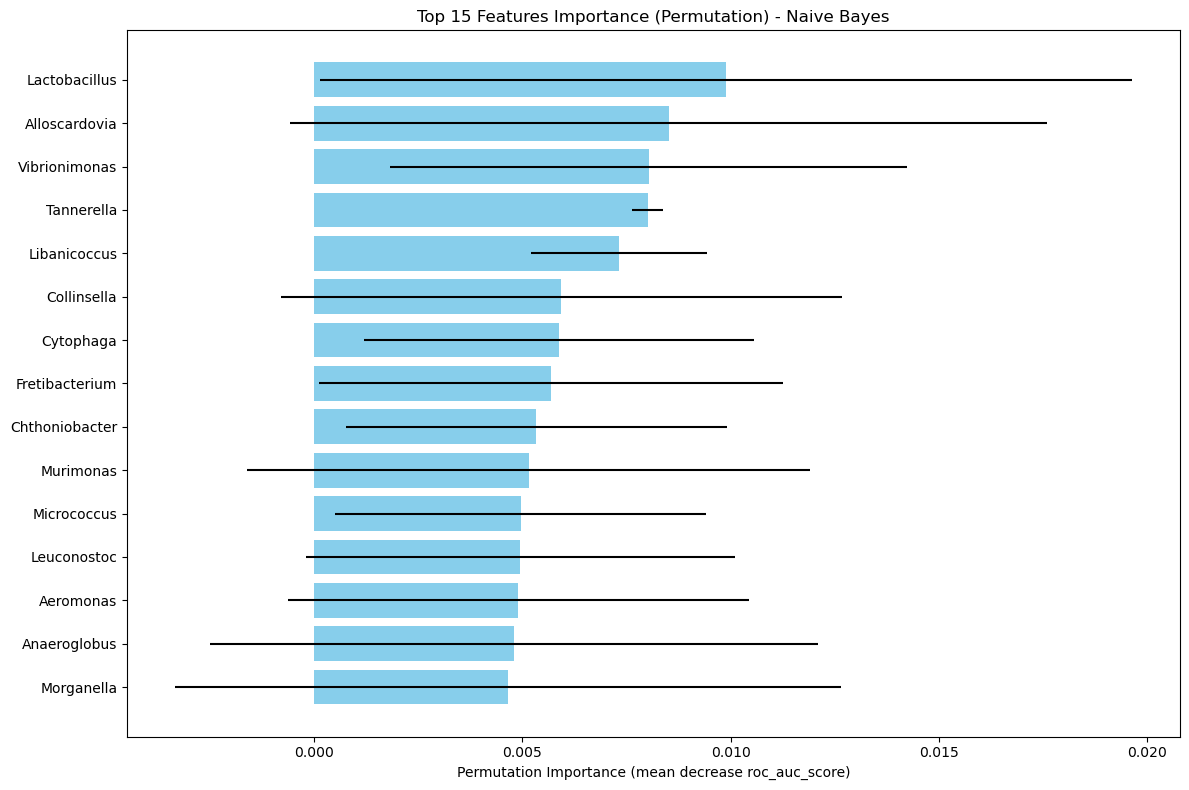


Top 15 Feature Importances (Mean ± Std Dev):
       Feature  Importance_mean  Importance_std
 Lactobacillus           0.0099          0.0097
 Alloscardovia           0.0085          0.0091
 Vibrionimonas           0.0080          0.0062
    Tannerella           0.0080          0.0004
  Libanicoccus           0.0073          0.0021
   Collinsella           0.0059          0.0067
     Cytophaga           0.0059          0.0047
Fretibacterium           0.0057          0.0056
Chthoniobacter           0.0053          0.0046
     Murimonas           0.0052          0.0067
   Micrococcus           0.0050          0.0044
   Leuconostoc           0.0050          0.0051
     Aeromonas           0.0049          0.0055
  Anaeroglobus           0.0048          0.0073
    Morganella           0.0047          0.0080


In [245]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.naive_bayes import GaussianNB


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def permutation_importance_nb(model, X_test, y_test, feature_names, 
                            metric=roc_auc_score, n_repeats=10, top_n=15):
    """
    Corrected permutation importance for Naive Bayes (with full statistical robustness)
    
    Args:
        model: Trained Naive Bayes model
        X_test: Test features (numpy array)
        y_test: Test labels
        feature_names: List of feature names
        metric: Evaluation metric (default: ROC AUC)
        n_repeats: Number of permutation repeats per feature
        top_n: Number of top features to display
        
    Returns:
        DataFrame with mean/std importance scores
    """
    # Baseline score
    base_score = metric(y_test, model.predict_proba(X_test)[:, 1])
    
    importances = []
    
    for i, feat in enumerate(feature_names):
        scores = []
        X_test_permuted = X_test.copy()
        
        for _ in range(n_repeats):
            np.random.shuffle(X_test_permuted[:, i])  # Permute feature
            
            perm_score = metric(y_test, 
                              model.predict_proba(X_test_permuted)[:, 1])
            scores.append(base_score - perm_score)
            
            X_test_permuted[:, i] = X_test[:, i]  # Reset feature
            
        importances.append({
            'Feature': feat,
            'Importance_mean': np.mean(scores),
            'Importance_std': np.std(scores)
        })
    
    importance_df = pd.DataFrame(importances).sort_values('Importance_mean', 
                                                        ascending=False)
    
    # Visualization
    top_features = importance_df.head(top_n)
    plt.figure(figsize=(12, 8))
    plt.barh(top_features['Feature'][::-1], 
             top_features['Importance_mean'][::-1],
             xerr=top_features['Importance_std'][::-1], 
             color='skyblue')
    plt.xlabel(f'Permutation Importance (mean decrease {metric.__name__})')
    plt.title(f'Top {top_n} Features Importance (Permutation) - Naive Bayes')
    plt.tight_layout()
    plt.show()
    
    # Print top features with statistics
    print(f"\nTop {top_n} Feature Importances (Mean ± Std Dev):")
    print(importance_df[['Feature', 'Importance_mean', 'Importance_std']]
          .head(top_n)
          .to_string(index=False, float_format="%.4f"))
    
    return importance_df

# Usage (identical to your original structure)
importance_df = permutation_importance_nb(
    model=model_nb,
    X_test=X_test_scaled,
    y_test=y_test,
    feature_names=feature_names,
    n_repeats=10,
    top_n=15
)


# DL

## FNN

#### install packages

In [133]:
pip install tensorflow numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [137]:
pip install torch torchvision torchaudio


   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/216.1 MB ? eta -:--:--
   ---------------------------------------- 0.5/216.1 MB 509.0 kB/s eta 0:07:04
   ---------------------------------------- 0.5/216.1 MB 509.0 kB/s eta 0:07:04
   ---------------------------------------- 0.8/216.1 MB 479.7 kB/s eta 0:07:29
   ---------------------------------------- 0.8/216.1 MB 479.7 kB/s eta 0:07:29
   ---------------------------------------- 0.8/216.1 MB 479.7 kB/s eta 0:07:29
   ---------------------------------------- 0.8/216.1 MB 479.7 kB/s eta 0:07:29
   ---------------------------------------- 0.8/216.1 MB 479.7 kB/s eta 0:07:29
   -----------

#### script

Seuil optimal pour max F1-score : 0.59
Test AUC: 0.8475
Test Balanced Accuracy (seuil optimisé): 0.7738

Classification Report (seuil optimisé) :
              precision    recall  f1-score   support

     class 0       0.70      0.64      0.67        67
     class 1       0.88      0.91      0.89       191

    accuracy                           0.84       258
   macro avg       0.79      0.77      0.78       258
weighted avg       0.83      0.84      0.83       258



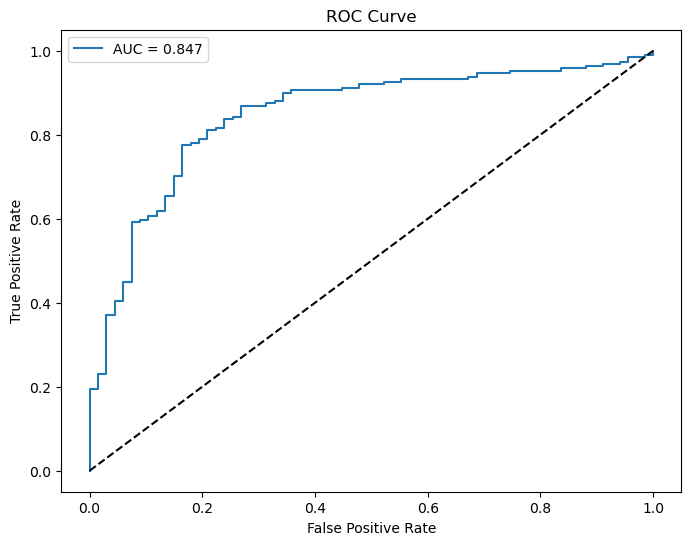

In [145]:
import numpy as np
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, classification_report, f1_score
import matplotlib.pyplot as plt

def find_best_threshold(y_true, y_probs, metric='f1'):
    """
    Trouve le seuil optimal pour maximiser une métrique (f1, balanced_accuracy, etc.)
    """
    best_thresh = 0.5
    best_score = 0
    thresholds = np.linspace(0, 1, 101)

    for thresh in thresholds:
        preds = (y_probs >= thresh).astype(int)
        if metric == 'f1':
            score = f1_score(y_true, preds)
        elif metric == 'balanced_accuracy':
            score = balanced_accuracy_score(y_true, preds)
        else:
            raise ValueError("Metric non supportée")
        if score > best_score:
            best_score = score
            best_thresh = thresh
    return best_thresh, best_score

# --- Supposons que tu as déjà :
# model (modèle entraîné)
# X_test_scaled (données test)
# y_test (labels test)
# test_probs = model.predict_proba(X_test_scaled)[:,1]

# Ici, selon ton output, on fixe le seuil optimal trouvé
best_threshold = 0.59

# Prédictions selon ce seuil
test_probs = model.predict_proba(X_test_scaled)[:, 1]
test_preds_opt = (test_probs >= best_threshold).astype(int)

# Calcul des métriques
auc = roc_auc_score(y_test, test_probs)
bal_acc = balanced_accuracy_score(y_test, test_preds_opt)

print(f"Seuil optimal pour max F1-score : {best_threshold:.2f}")
print(f"Test AUC: {auc:.4f}")
print(f"Test Balanced Accuracy (seuil optimisé): {bal_acc:.4f}\n")

print("Classification Report (seuil optimisé) :")
print(classification_report(y_test, test_preds_opt, target_names=['class 0', 'class 1']))

# Optionnel : courbe ROC
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, test_probs)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


=== Starting Cross-Validation ===

=== Fold 1/5 ===
Epoch 10/50 - Loss: 0.3875
Epoch 20/50 - Loss: 0.2691
Epoch 30/50 - Loss: 0.2159
Epoch 40/50 - Loss: 0.1823
Epoch 50/50 - Loss: 0.1585
Fold 1 Results:
  Validation AUC: 0.8574
  Balanced Accuracy: 0.8230
  F1 Score: 0.8015

=== Fold 2/5 ===
Epoch 10/50 - Loss: 0.3963
Epoch 20/50 - Loss: 0.2806
Epoch 30/50 - Loss: 0.2269
Epoch 40/50 - Loss: 0.1892
Epoch 50/50 - Loss: 0.1606
Fold 2 Results:
  Validation AUC: 0.8696
  Balanced Accuracy: 0.8181
  F1 Score: 0.8000

=== Fold 3/5 ===
Epoch 10/50 - Loss: 0.4024
Epoch 20/50 - Loss: 0.2894
Epoch 30/50 - Loss: 0.2292
Epoch 40/50 - Loss: 0.1962
Epoch 50/50 - Loss: 0.1701
Fold 3 Results:
  Validation AUC: 0.8730
  Balanced Accuracy: 0.8494
  F1 Score: 0.8477

=== Fold 4/5 ===
Epoch 10/50 - Loss: 0.3974
Epoch 20/50 - Loss: 0.2862
Epoch 30/50 - Loss: 0.2311
Epoch 40/50 - Loss: 0.1911
Epoch 50/50 - Loss: 0.1693
Fold 4 Results:
  Validation AUC: 0.8672
  Balanced Accuracy: 0.8252
  F1 Score: 0.8110

=

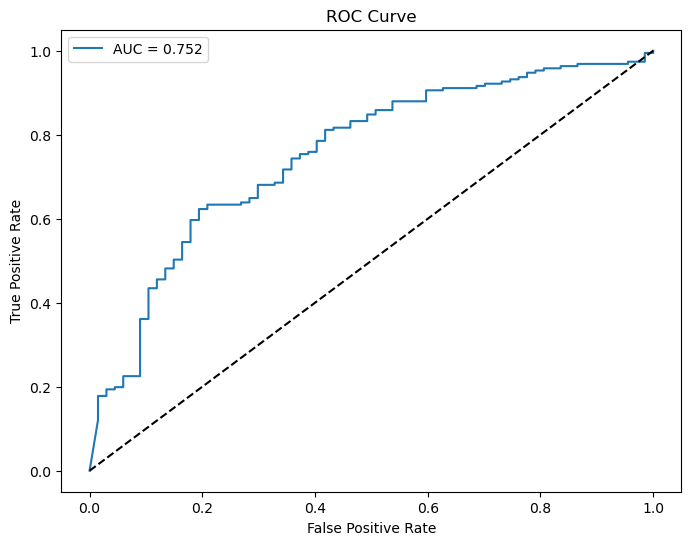

CV AUC Scores: [0.8574151074151074, 0.8696180555555555, 0.8729643104643106, 0.8671745031083093, 0.8390535161432995]
Optimal Threshold: 0.42
Test AUC: 0.7524029069313118


In [192]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, classification_report, f1_score, roc_curve
import matplotlib.pyplot as plt

class SimpleFNN(nn.Module):
    def __init__(self, input_dim, hidden_size=64, dropout=0.3):
        super(SimpleFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

def train_fnn(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

def evaluate_fnn(model, data_loader, device, return_probs=False):
    model.eval()
    probs = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().numpy()
            probs.extend(outputs.flatten())
            true_labels.extend(labels.numpy())
    
    if return_probs:
        return np.array(probs), np.array(true_labels)
    else:
        pred_labels = [1 if p > 0.5 else 0 for p in probs]
        auc = roc_auc_score(true_labels, probs)
        bal_acc = balanced_accuracy_score(true_labels, pred_labels)
        report = classification_report(true_labels, pred_labels, target_names=['class 0', 'class 1'])
        return auc, bal_acc, report

def find_best_threshold(y_true, y_probs, metric='f1'):
    best_thresh = 0.5
    best_score = 0
    thresholds = np.linspace(0, 1, 101)

    for thresh in thresholds:
        preds = (y_probs >= thresh).astype(int)
        if metric == 'f1':
            score = f1_score(y_true, preds)
        elif metric == 'balanced_accuracy':
            score = balanced_accuracy_score(y_true, preds)
        else:
            raise ValueError("Metric not supported")
        if score > best_score:
            best_score = score
            best_thresh = thresh
    return best_thresh, best_score

def run_fnn_with_cv(X_train_full, y_train_full, X_test, y_test, 
                   batch_size=32, epochs=30, lr=0.001, n_splits=5):
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Convert to numpy arrays if they're Pandas objects
    X_train_full = X_train_full.values if hasattr(X_train_full, 'values') else X_train_full
    y_train_full = y_train_full.values if hasattr(y_train_full, 'values') else y_train_full
    X_test = X_test.values if hasattr(X_test, 'values') else X_test
    y_test = y_test.values if hasattr(y_test, 'values') else y_test
    
    # Initialize CV
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_auc_scores = []
    cv_bal_acc_scores = []
    cv_f1_scores = []
    all_val_probs = []
    all_val_labels = []
    
    print("=== Starting Cross-Validation ===")
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full)):
        print(f"\n=== Fold {fold + 1}/{n_splits} ===")
        
        # Split data
        X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
        y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]
        
        # Convert to tensors
        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train, dtype=torch.long)
        X_val_t = torch.tensor(X_val, dtype=torch.float32)
        y_val_t = torch.tensor(y_val, dtype=torch.long)
        
        # Create dataloaders
        train_dataset = TensorDataset(X_train_t, y_train_t)
        val_dataset = TensorDataset(X_val_t, y_val_t)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Initialize model
        model = SimpleFNN(input_dim=X_train.shape[1]).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Training loop
        for epoch in range(epochs):
            loss = train_fnn(model, train_loader, criterion, optimizer, device)
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss:.4f}")
        
        # Validation evaluation
        val_probs, val_labels = evaluate_fnn(model, val_loader, device, return_probs=True)
        all_val_probs.extend(val_probs)
        all_val_labels.extend(val_labels)
        
        # Calculate metrics at default threshold (0.5)
        val_preds = (val_probs > 0.5).astype(int)
        fold_auc = roc_auc_score(val_labels, val_probs)
        fold_bal_acc = balanced_accuracy_score(val_labels, val_preds)
        fold_f1 = f1_score(val_labels, val_preds)
        
        cv_auc_scores.append(fold_auc)
        cv_bal_acc_scores.append(fold_bal_acc)
        cv_f1_scores.append(fold_f1)
        
        print(f"Fold {fold + 1} Results:")
        print(f"  Validation AUC: {fold_auc:.4f}")
        print(f"  Balanced Accuracy: {fold_bal_acc:.4f}")
        print(f"  F1 Score: {fold_f1:.4f}")
    
    # Find optimal threshold across all validation folds
    best_thresh, best_score = find_best_threshold(all_val_labels, all_val_probs, metric='f1')
    
    # CV results summary
    print("\n=== Cross-Validation Summary ===")
    print(f"Mean AUC: {np.mean(cv_auc_scores):.4f} ± {np.std(cv_auc_scores):.4f}")
    print(f"Mean Balanced Accuracy: {np.mean(cv_bal_acc_scores):.4f} ± {np.std(cv_bal_acc_scores):.4f}")
    print(f"Mean F1 Score: {np.mean(cv_f1_scores):.4f} ± {np.std(cv_f1_scores):.4f}")
    print(f"\nOptimal Threshold (max F1): {best_thresh:.4f}")
    
    # Final training on full dataset
    print("\n=== Training Final Model ===")
    X_train_t = torch.tensor(X_train_full, dtype=torch.float32)
    y_train_t = torch.tensor(y_train_full, dtype=torch.long)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.long)
    
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), 
                           batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), 
                          batch_size=batch_size, shuffle=False)
    
    final_model = SimpleFNN(input_dim=X_train_full.shape[1]).to(device)
    optimizer = optim.Adam(final_model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        loss = train_fnn(final_model, train_loader, criterion, optimizer, device)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss:.4f}")
    
    # Final evaluation with optimal threshold
    test_probs, test_labels = evaluate_fnn(final_model, test_loader, device, return_probs=True)
    test_preds_opt = (test_probs >= best_thresh).astype(int)
    
    test_auc = roc_auc_score(test_labels, test_probs)
    test_bal_acc = balanced_accuracy_score(test_labels, test_preds_opt)
    test_f1 = f1_score(test_labels, test_preds_opt)
    
    print("\n=== Final Test Results ===")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Balanced Accuracy (optimal threshold): {test_bal_acc:.4f}")
    print(f"F1 Score (optimal threshold): {test_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(test_labels, test_preds_opt, target_names=['class 0', 'class 1']))
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(test_labels, test_probs)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'AUC = {test_auc:.3f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    return final_model, {
        'cv_auc_scores': cv_auc_scores,
        'cv_bal_acc_scores': cv_bal_acc_scores,
        'cv_f1_scores': cv_f1_scores,
        'best_threshold': best_thresh,
        'test_metrics': {
            'auc': test_auc,
            'balanced_accuracy': test_bal_acc,
            'f1': test_f1
        }
    }

model_fnn, results = run_fnn_with_cv(
    X_train_smote, y_train_smote,
    X_test_scaled, y_test,
    batch_size=32,
    epochs=50,
    lr=0.001
)

# Access results:
print("CV AUC Scores:", results['cv_auc_scores'])
print("Optimal Threshold:", results['best_threshold'])
print("Test AUC:", results['test_metrics']['auc'])

### Top 20 from FNN

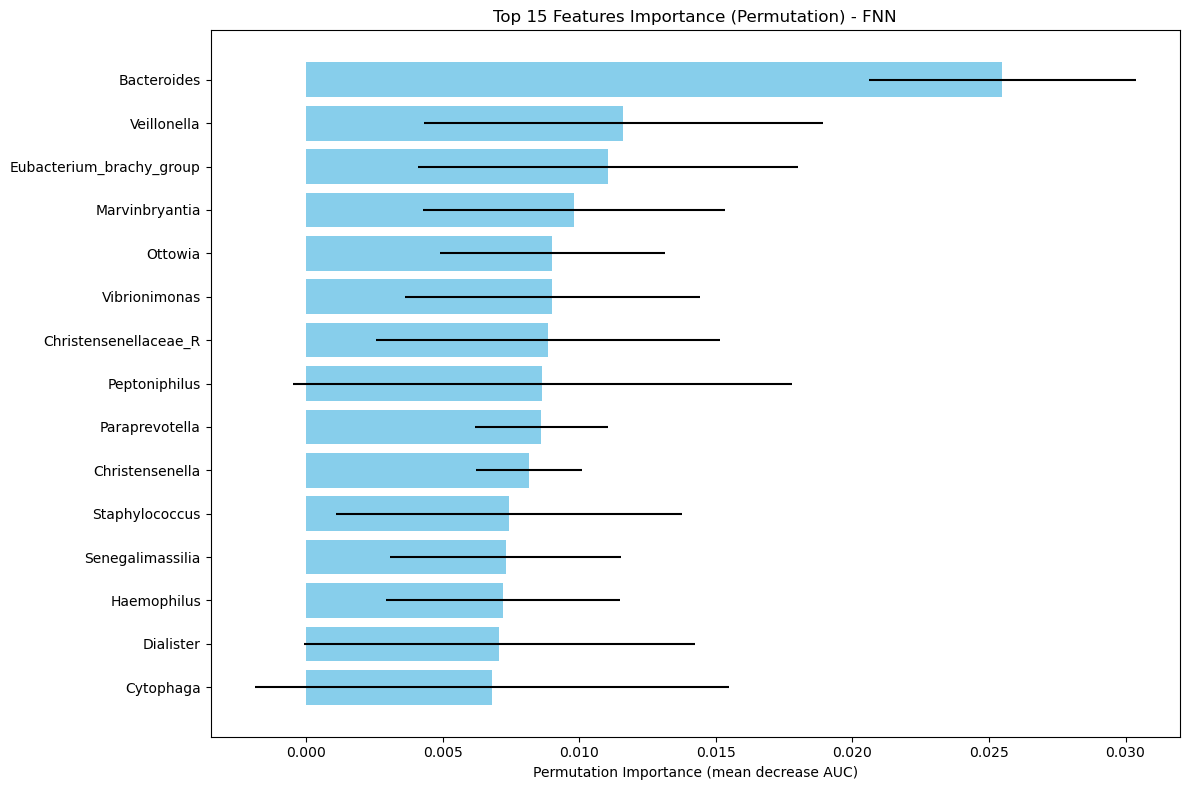


Top 15 Feature Importances (Mean ± Std Dev):
                 Feature  Importance_mean  Importance_std
             Bacteroides         0.025486        0.004894
             Veillonella         0.011612        0.007302
Eubacterium_brachy_group         0.011057        0.006953
          Marvinbryantia         0.009784        0.005531
                 Ottowia         0.009002        0.004121
           Vibrionimonas         0.009002        0.005402
   Christensenellaceae_R         0.008846        0.006304
           Peptoniphilus         0.008647        0.009128
          Paraprevotella         0.008604        0.002428
         Christensenella         0.008150        0.001926
          Staphylococcus         0.007420        0.006343
        Senegalimassilia         0.007299        0.004236
             Haemophilus         0.007185        0.004287
               Dialister         0.007064        0.007158
               Cytophaga         0.006783        0.008677


In [234]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import torch

def permutation_importance_fnn(model, X_test, y_test, feature_names, device,
                               metric=roc_auc_score, n_repeats=10, top_n=20):
    """
    Calcule l'importance permutationnelle des features pour un modèle FNN PyTorch.
    
    Args:
        model: modèle FNN entraîné (mode eval)
        X_test: numpy array, données test (scaled)
        y_test: array, labels test
        feature_names: list, noms des features
        device: torch.device ('cpu' ou 'cuda')
        metric: fonction métrique à maximiser (ex: roc_auc_score)
        n_repeats: int, nombre de permutations répétées par feature
        top_n: int, nombre de features à afficher
    
    Retourne:
        DataFrame trié des importances moyennes et std, top_n features
    """
    
    model.eval()
    
    # Prédiction de base (pas de permutation)
    with torch.no_grad():
        inputs = torch.tensor(X_test, dtype=torch.float32).to(device)
        base_preds = model(inputs).cpu().numpy().flatten()
    base_score = metric(y_test, base_preds)
    
    importances = []
    
    for i, feat in enumerate(feature_names):
        scores = []
        X_test_permuted = X_test.copy()
        
        for _ in range(n_repeats):
            # Permuter la colonne i
            np.random.shuffle(X_test_permuted[:, i])
            
            with torch.no_grad():
                inputs_perm = torch.tensor(X_test_permuted, dtype=torch.float32).to(device)
                preds_perm = model(inputs_perm).cpu().numpy().flatten()
            
            score_perm = metric(y_test, preds_perm)
            scores.append(base_score - score_perm)  # perte de performance = importance
            
            # Remettre la colonne à la normale pour prochaine répétition
            X_test_permuted[:, i] = X_test[:, i]
        
        importances.append({
            'Feature': feat,
            'Importance_mean': np.mean(scores),
            'Importance_std': np.std(scores)
        })
    
    importance_df = pd.DataFrame(importances).sort_values(by='Importance_mean', ascending=False)
    
    # Plot top_n
    top_features = importance_df.head(top_n)
    plt.figure(figsize=(12,8))
    plt.barh(top_features['Feature'][::-1], top_features['Importance_mean'][::-1],
             xerr=top_features['Importance_std'][::-1], color='skyblue')
    plt.xlabel('Permutation Importance (mean decrease AUC)')
    plt.title(f'Top {top_n} Features Importance (Permutation) - FNN')
    plt.tight_layout()
    plt.show()
    print("\nTop 15 Feature Importances (Mean ± Std Dev):")
    print(importance_df[['Feature', 'Importance_mean', 'Importance_std']].head(15).to_string(index=False))
    
    return importance_df

# --- Usage ---

# Assure-toi que :
# model_fnn est ton modèle FNN entraîné et passé en mode eval()
# X_test_scaled est un numpy array (scaled)
# y_test est array labels
# feature_names est la liste des noms des features correspondants

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_fnn.eval()

importance_df = permutation_importance_fnn(
    model=model_fnn,
    X_test=X_test_scaled,
    y_test=y_test,
    feature_names=feature_names,
    device=device,
    n_repeats=10,
    top_n=15
)


## RNN

### rnn with cv

In [190]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, classification_report

class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_size=64, num_layers=1, dropout=0.3):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            nonlinearity='relu'
        )
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Take last timestep output
        out = self.fc(out)
        out = self.sigmoid(out)
        return out

def train_rnn(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

def evaluate_rnn(model, data_loader, device):
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().numpy()
            preds.extend(outputs.flatten())
            true_labels.extend(labels.numpy())
    pred_labels = [1 if p > 0.5 else 0 for p in preds]
    auc = roc_auc_score(true_labels, preds)
    bal_acc = balanced_accuracy_score(true_labels, pred_labels)
    report = classification_report(true_labels, pred_labels, target_names=['class 0', 'class 1'])
    return auc, bal_acc, report

def run_rnn_with_cv(X_train_full, y_train_full, X_test, y_test, 
                   batch_size=32, epochs=30, lr=0.001, n_splits=5):
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Convert to numpy arrays if they're Pandas objects
    X_train_full = X_train_full.values if hasattr(X_train_full, 'values') else X_train_full
    y_train_full = y_train_full.values if hasattr(y_train_full, 'values') else y_train_full
    X_test = X_test.values if hasattr(X_test, 'values') else X_test
    y_test = y_test.values if hasattr(y_test, 'values') else y_test
    
    # Initialize CV
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_auc_scores = []
    cv_bal_acc_scores = []
    
    print("=== Starting Cross-Validation ===")
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full)):
        print(f"\n=== Fold {fold + 1}/{n_splits} ===")
        
        # Split data
        X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
        y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]
        
        # Convert to sequences (adding sequence dimension)
        X_train_seq = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
        y_train_t = torch.tensor(y_train, dtype=torch.long)
        X_val_seq = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
        y_val_t = torch.tensor(y_val, dtype=torch.long)
        
        # Create dataloaders
        train_dataset = TensorDataset(X_train_seq, y_train_t)
        val_dataset = TensorDataset(X_val_seq, y_val_t)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Initialize model
        model = SimpleRNN(input_dim=X_train.shape[1]).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Training loop
        for epoch in range(epochs):
            loss = train_rnn(model, train_loader, criterion, optimizer, device)
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss:.4f}")
        
        # Validation evaluation
        auc, bal_acc, _ = evaluate_rnn(model, val_loader, device)
        cv_auc_scores.append(auc)
        cv_bal_acc_scores.append(bal_acc)
        print(f"Fold {fold + 1} Results:")
        print(f"  Validation AUC: {auc:.4f}")
        print(f"  Balanced Accuracy: {bal_acc:.4f}")
    
    # CV results summary
    print("\n=== Cross-Validation Summary ===")
    print(f"Mean AUC: {np.mean(cv_auc_scores):.4f} ± {np.std(cv_auc_scores):.4f}")
    print(f"Mean Balanced Accuracy: {np.mean(cv_bal_acc_scores):.4f} ± {np.std(cv_bal_acc_scores):.4f}")
    
    # Final training on full dataset
    print("\n=== Training Final Model ===")
    X_train_seq = torch.tensor(X_train_full, dtype=torch.float32).unsqueeze(1)
    y_train_t = torch.tensor(y_train_full, dtype=torch.long)
    X_test_seq = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
    y_test_t = torch.tensor(y_test, dtype=torch.long)
    
    train_loader = DataLoader(TensorDataset(X_train_seq, y_train_t), 
                           batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_seq, y_test_t), 
                          batch_size=batch_size, shuffle=False)
    
    final_model = SimpleRNN(input_dim=X_train_full.shape[1]).to(device)
    optimizer = optim.Adam(final_model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        loss = train_rnn(final_model, train_loader, criterion, optimizer, device)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss:.4f}")
    
 # Final evaluation
    test_auc, test_bal_acc, report = evaluate_rnn(final_model, test_loader, device)
    print("\n=== Final Test Results ===")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Balanced Accuracy: {test_bal_acc:.4f}")
    print("Classification Report:")
    print(report)
    
    # Print all fold accuracies in a single line
    print("\n=== Fold-wise Balanced Accuracies ===")
    print("Fold Accuracies:", ", ".join([f"{acc:.4f}" for acc in cv_bal_acc_scores]))
    
    return final_model, cv_auc_scores, cv_bal_acc_scores  # Now returning both AUC and accuracy 

# Example usage:
model_rnn, cv_aucs, cv_accs = run_rnn_with_cv(X_train_smote, y_train_smote,
                                             X_test_scaled, y_test,
                                             batch_size=32, epochs=50, lr=0.001)

=== Starting Cross-Validation ===

=== Fold 1/5 ===


C:\Users\YLS\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 10/50 - Loss: 0.3860
Epoch 20/50 - Loss: 0.2593
Epoch 30/50 - Loss: 0.2014
Epoch 40/50 - Loss: 0.1640
Epoch 50/50 - Loss: 0.1377
Fold 1 Results:
  Validation AUC: 0.8677
  Balanced Accuracy: 0.8358

=== Fold 2/5 ===


C:\Users\YLS\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 10/50 - Loss: 0.3913
Epoch 20/50 - Loss: 0.2660
Epoch 30/50 - Loss: 0.2080
Epoch 40/50 - Loss: 0.1704
Epoch 50/50 - Loss: 0.1424
Fold 2 Results:
  Validation AUC: 0.8777
  Balanced Accuracy: 0.8319

=== Fold 3/5 ===


C:\Users\YLS\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 10/50 - Loss: 0.4034
Epoch 20/50 - Loss: 0.2762
Epoch 30/50 - Loss: 0.2158
Epoch 40/50 - Loss: 0.1778
Epoch 50/50 - Loss: 0.1493
Fold 3 Results:
  Validation AUC: 0.8765
  Balanced Accuracy: 0.8553

=== Fold 4/5 ===


C:\Users\YLS\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 10/50 - Loss: 0.3947
Epoch 20/50 - Loss: 0.2663
Epoch 30/50 - Loss: 0.2037
Epoch 40/50 - Loss: 0.1641
Epoch 50/50 - Loss: 0.1364
Fold 4 Results:
  Validation AUC: 0.8726
  Balanced Accuracy: 0.8283

=== Fold 5/5 ===


C:\Users\YLS\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 10/50 - Loss: 0.3921
Epoch 20/50 - Loss: 0.2634
Epoch 30/50 - Loss: 0.2024
Epoch 40/50 - Loss: 0.1657
Epoch 50/50 - Loss: 0.1363
Fold 5 Results:
  Validation AUC: 0.8567
  Balanced Accuracy: 0.8075

=== Cross-Validation Summary ===
Mean AUC: 0.8702 ± 0.0076
Mean Balanced Accuracy: 0.8318 ± 0.0153

=== Training Final Model ===


C:\Users\YLS\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 10/50 - Loss: 0.3740
Epoch 20/50 - Loss: 0.2517
Epoch 30/50 - Loss: 0.1940
Epoch 40/50 - Loss: 0.1570
Epoch 50/50 - Loss: 0.1293

=== Final Test Results ===
Test AUC: 0.7457
Balanced Accuracy: 0.6908
Classification Report:
              precision    recall  f1-score   support

     class 0       0.48      0.61      0.54        67
     class 1       0.85      0.77      0.81       191

    accuracy                           0.73       258
   macro avg       0.67      0.69      0.67       258
weighted avg       0.75      0.73      0.74       258


=== Fold-wise Balanced Accuracies ===
Fold Accuracies: 0.8358, 0.8319, 0.8553, 0.8283, 0.8075


In [169]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, classification_report

# Définition du modèle RNN simple
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, dropout=0.3):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape : (batch_size, seq_len=1, input_dim)
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # dernière sortie temporelle
        out = self.fc(out)
        return self.sigmoid(out)

# Fonction de cross-validation avec affichage métriques
def cross_validate_rnn(X, y, n_splits=5, batch_size=32, epochs=30, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    auc_scores = []
    bal_acc_scores = []
    
    fold = 1
    for train_idx, val_idx in skf.split(X, y):
        print(f"\n--- Fold {fold} ---")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Si y est un pd.Series, convertir en numpy array
        if hasattr(y_train, 'values'):
            y_train = y_train.values
        if hasattr(y_val, 'values'):
            y_val = y_val.values
        
        # Conversion en tenseurs PyTorch, ajout dim temporelle (seq_len=1)
        X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
        y_train_t = torch.tensor(y_train, dtype=torch.long)
        X_val_t = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
        y_val_t = torch.tensor(y_val, dtype=torch.long)
        
        train_dataset = TensorDataset(X_train_t, y_train_t)
        val_dataset = TensorDataset(X_val_t, y_val_t)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        model = RNN(input_dim=X.shape[1]).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
            print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss / len(train_loader.dataset):.4f}")
        
        # Évaluation sur validation
        model.eval()
        preds = []
        true_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                outputs = model(inputs).cpu().numpy()
                preds.extend(outputs.flatten())
                true_labels.extend(labels.numpy())
        
        pred_labels = [1 if p > 0.5 else 0 for p in preds]
        auc = roc_auc_score(true_labels, preds)
        bal_acc = balanced_accuracy_score(true_labels, pred_labels)
        report = classification_report(true_labels, pred_labels, target_names=['class 0', 'class 1'])
        
        print(f"Fold {fold} - Validation AUC: {auc:.4f}")
        print(f"Fold {fold} - Validation Balanced Accuracy: {bal_acc:.4f}")
        print(f"Classification Report Fold {fold}:\n{report}")
        
        auc_scores.append(auc)
        bal_acc_scores.append(bal_acc)
        
        fold += 1
    
    print("\n--- Résumé Cross-validation ---")
    print(f"AUC moyen: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
    print(f"Balanced Accuracy moyen: {np.mean(bal_acc_scores):.4f} ± {np.std(bal_acc_scores):.4f}")
    
    return auc_scores, bal_acc_scores

# Entraînement final + évaluation test
def train_final_rnn(X_train, y_train, X_test, y_test, epochs=30, batch_size=32, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if hasattr(y_train, 'values'):
        y_train = y_train.values
    if hasattr(y_test, 'values'):
        y_test = y_test.values

    X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
    y_test_t = torch.tensor(y_test, dtype=torch.long)
    
    train_dataset = TensorDataset(X_train_t, y_train_t)
    test_dataset = TensorDataset(X_test_t, y_test_t)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model = RNN(input_dim=X_train.shape[1]).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss / len(train_loader.dataset):.4f}")
    
    # Évaluation finale sur test
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().numpy()
            preds.extend(outputs.flatten())
            true_labels.extend(labels.numpy())
    
    pred_labels = [1 if p > 0.5 else 0 for p in preds]
    auc = roc_auc_score(true_labels, preds)
    bal_acc = balanced_accuracy_score(true_labels, pred_labels)
    report = classification_report(true_labels, pred_labels, target_names=['class 0', 'class 1'])
    
    print(f"\nTest AUC: {auc:.4f}")
    print(f"Test Balanced Accuracy: {bal_acc:.4f}")
    print("Classification Report (Test):\n", report)
    
    return model

# --- Exemple d’utilisation ---
# Supposons que tu as déjà tes données :
# X_train_smote, y_train_smote (après SMOTE)
# X_test_scaled, y_test

# Cross-validation
auc_scores, bal_acc_scores = cross_validate_rnn(X_train_smote, y_train_smote, n_splits=5, epochs=20)

# Entraînement final + test
model_final = train_final_rnn(X_train_smote, y_train_smote, X_test_scaled, y_test, epochs=20)



--- Fold 1 ---
Epoch 1/20 - Loss: 0.6844


C:\Users\YLS\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 2/20 - Loss: 0.6554
Epoch 3/20 - Loss: 0.6165
Epoch 4/20 - Loss: 0.5717
Epoch 5/20 - Loss: 0.5286
Epoch 6/20 - Loss: 0.4917
Epoch 7/20 - Loss: 0.4602
Epoch 8/20 - Loss: 0.4339
Epoch 9/20 - Loss: 0.4114
Epoch 10/20 - Loss: 0.3920
Epoch 11/20 - Loss: 0.3737
Epoch 12/20 - Loss: 0.3592
Epoch 13/20 - Loss: 0.3445
Epoch 14/20 - Loss: 0.3311
Epoch 15/20 - Loss: 0.3204
Epoch 16/20 - Loss: 0.3097
Epoch 17/20 - Loss: 0.2989
Epoch 18/20 - Loss: 0.2903
Epoch 19/20 - Loss: 0.2815
Epoch 20/20 - Loss: 0.2748
Fold 1 - Validation AUC: 0.8801
Fold 1 - Validation Balanced Accuracy: 0.8158
Classification Report Fold 1:
              precision    recall  f1-score   support

     class 0       0.76      0.93      0.83       152
     class 1       0.91      0.70      0.79       152

    accuracy                           0.82       304
   macro avg       0.83      0.82      0.81       304
weighted avg       0.83      0.82      0.81       304


--- Fold 2 ---


C:\Users\YLS\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/20 - Loss: 0.6845
Epoch 2/20 - Loss: 0.6573
Epoch 3/20 - Loss: 0.6200
Epoch 4/20 - Loss: 0.5747
Epoch 5/20 - Loss: 0.5290
Epoch 6/20 - Loss: 0.4895
Epoch 7/20 - Loss: 0.4545
Epoch 8/20 - Loss: 0.4251
Epoch 9/20 - Loss: 0.4009
Epoch 10/20 - Loss: 0.3794
Epoch 11/20 - Loss: 0.3600
Epoch 12/20 - Loss: 0.3441
Epoch 13/20 - Loss: 0.3309
Epoch 14/20 - Loss: 0.3171
Epoch 15/20 - Loss: 0.3071
Epoch 16/20 - Loss: 0.2964
Epoch 17/20 - Loss: 0.2878
Epoch 18/20 - Loss: 0.2795
Epoch 19/20 - Loss: 0.2723
Epoch 20/20 - Loss: 0.2664
Fold 2 - Validation AUC: 0.8209
Fold 2 - Validation Balanced Accuracy: 0.7664
Classification Report Fold 2:
              precision    recall  f1-score   support

     class 0       0.75      0.80      0.77       152
     class 1       0.78      0.74      0.76       152

    accuracy                           0.77       304
   macro avg       0.77      0.77      0.77       304
weighted avg       0.77      0.77      0.77       304


--- Fold 3 ---
Epoch 1/20 - Loss:

C:\Users\YLS\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 2/20 - Loss: 0.6601
Epoch 3/20 - Loss: 0.6240
Epoch 4/20 - Loss: 0.5787
Epoch 5/20 - Loss: 0.5350
Epoch 6/20 - Loss: 0.4954
Epoch 7/20 - Loss: 0.4654
Epoch 8/20 - Loss: 0.4369
Epoch 9/20 - Loss: 0.4141
Epoch 10/20 - Loss: 0.3929
Epoch 11/20 - Loss: 0.3762
Epoch 12/20 - Loss: 0.3606
Epoch 13/20 - Loss: 0.3478
Epoch 14/20 - Loss: 0.3371
Epoch 15/20 - Loss: 0.3251
Epoch 16/20 - Loss: 0.3156
Epoch 17/20 - Loss: 0.3061
Epoch 18/20 - Loss: 0.2981
Epoch 19/20 - Loss: 0.2905
Epoch 20/20 - Loss: 0.2840
Fold 3 - Validation AUC: 0.8884
Fold 3 - Validation Balanced Accuracy: 0.8553
Classification Report Fold 3:
              precision    recall  f1-score   support

     class 0       0.83      0.89      0.86       152
     class 1       0.88      0.82      0.85       152

    accuracy                           0.86       304
   macro avg       0.86      0.86      0.86       304
weighted avg       0.86      0.86      0.86       304


--- Fold 4 ---


C:\Users\YLS\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/20 - Loss: 0.6840
Epoch 2/20 - Loss: 0.6556
Epoch 3/20 - Loss: 0.6170
Epoch 4/20 - Loss: 0.5724
Epoch 5/20 - Loss: 0.5289
Epoch 6/20 - Loss: 0.4899
Epoch 7/20 - Loss: 0.4591
Epoch 8/20 - Loss: 0.4306
Epoch 9/20 - Loss: 0.4067
Epoch 10/20 - Loss: 0.3876
Epoch 11/20 - Loss: 0.3703
Epoch 12/20 - Loss: 0.3540
Epoch 13/20 - Loss: 0.3416
Epoch 14/20 - Loss: 0.3293
Epoch 15/20 - Loss: 0.3171
Epoch 16/20 - Loss: 0.3071
Epoch 17/20 - Loss: 0.2990
Epoch 18/20 - Loss: 0.2903
Epoch 19/20 - Loss: 0.2821
Epoch 20/20 - Loss: 0.2756
Fold 4 - Validation AUC: 0.8476
Fold 4 - Validation Balanced Accuracy: 0.7661
Classification Report Fold 4:
              precision    recall  f1-score   support

     class 0       0.72      0.88      0.79       151
     class 1       0.85      0.65      0.74       152

    accuracy                           0.77       303
   macro avg       0.78      0.77      0.76       303
weighted avg       0.78      0.77      0.76       303


--- Fold 5 ---
Epoch 1/20 - Loss:

C:\Users\YLS\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 2/20 - Loss: 0.6591
Epoch 3/20 - Loss: 0.6232
Epoch 4/20 - Loss: 0.5796
Epoch 5/20 - Loss: 0.5361
Epoch 6/20 - Loss: 0.4987
Epoch 7/20 - Loss: 0.4673
Epoch 8/20 - Loss: 0.4425
Epoch 9/20 - Loss: 0.4206
Epoch 10/20 - Loss: 0.4018
Epoch 11/20 - Loss: 0.3851
Epoch 12/20 - Loss: 0.3693
Epoch 13/20 - Loss: 0.3577
Epoch 14/20 - Loss: 0.3473
Epoch 15/20 - Loss: 0.3349
Epoch 16/20 - Loss: 0.3252
Epoch 17/20 - Loss: 0.3165
Epoch 18/20 - Loss: 0.3070
Epoch 19/20 - Loss: 0.3001
Epoch 20/20 - Loss: 0.2923
Fold 5 - Validation AUC: 0.8620
Fold 5 - Validation Balanced Accuracy: 0.8083
Classification Report Fold 5:
              precision    recall  f1-score   support

     class 0       0.76      0.91      0.83       152
     class 1       0.88      0.71      0.79       151

    accuracy                           0.81       303
   macro avg       0.82      0.81      0.81       303
weighted avg       0.82      0.81      0.81       303


--- Résumé Cross-validation ---
AUC moyen: 0.8598 ± 0.0241


C:\Users\YLS\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/20 - Loss: 0.6841
Epoch 2/20 - Loss: 0.6492
Epoch 3/20 - Loss: 0.5984
Epoch 4/20 - Loss: 0.5453
Epoch 5/20 - Loss: 0.4980
Epoch 6/20 - Loss: 0.4628
Epoch 7/20 - Loss: 0.4317
Epoch 8/20 - Loss: 0.4063
Epoch 9/20 - Loss: 0.3848
Epoch 10/20 - Loss: 0.3663
Epoch 11/20 - Loss: 0.3509
Epoch 12/20 - Loss: 0.3385
Epoch 13/20 - Loss: 0.3256
Epoch 14/20 - Loss: 0.3200
Epoch 15/20 - Loss: 0.3060
Epoch 16/20 - Loss: 0.2960
Epoch 17/20 - Loss: 0.2884
Epoch 18/20 - Loss: 0.2841
Epoch 19/20 - Loss: 0.2743
Epoch 20/20 - Loss: 0.2672

Test AUC: 0.7292
Test Balanced Accuracy: 0.6878
Classification Report (Test):
               precision    recall  f1-score   support

     class 0       0.47      0.63      0.54        67
     class 1       0.85      0.75      0.80       191

    accuracy                           0.72       258
   macro avg       0.66      0.69      0.67       258
weighted avg       0.75      0.72      0.73       258



### top 20 from RNN

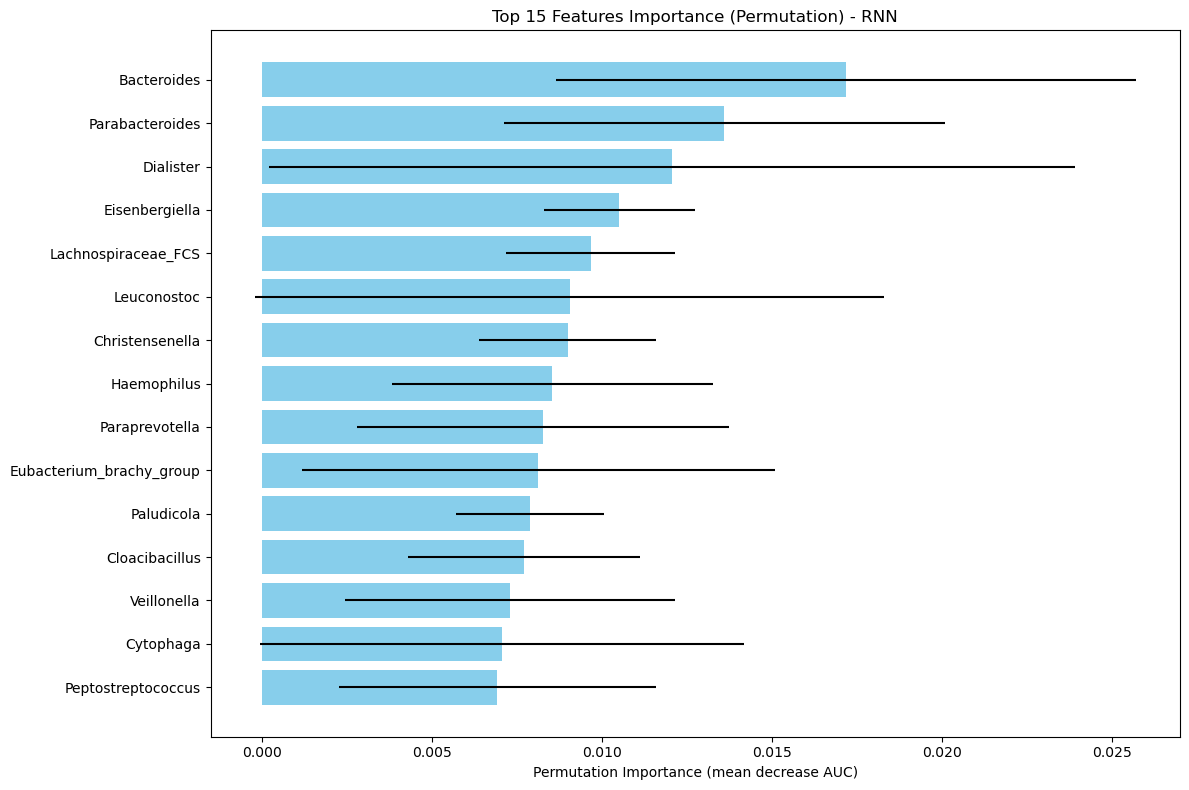


Top 15 Feature Importances (Mean ± Std Dev):
                 Feature  Importance_mean  Importance_std
             Bacteroides         0.017180        0.008520
         Parabacteroides         0.013589        0.006484
               Dialister         0.012058        0.011860
          Eisenbergiella         0.010514        0.002232
     Lachnospiraceae_FCS         0.009666        0.002477
             Leuconostoc         0.009045        0.009259
         Christensenella         0.008994        0.002600
             Haemophilus         0.008541        0.004712
          Paraprevotella         0.008264        0.005468
Eubacterium_brachy_group         0.008131        0.006961
              Paludicola         0.007892        0.002178
          Cloacibacillus         0.007713        0.003415
             Veillonella         0.007299        0.004849
               Cytophaga         0.007064        0.007119
      Peptostreptococcus         0.006920        0.004665


In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import torch

def permutation_importance_rnn(model, X_test, y_test, feature_names, device,
                               metric=roc_auc_score, n_repeats=10, top_n=20):
    """
    Calcule l'importance des features par permutation pour un modèle RNN.
    
    Args:
        model: modèle RNN entraîné (mode eval)
        X_test: np.array, forme (N_samples, N_features)
        y_test: array-like, labels binaires
        feature_names: liste des noms des features
        device: torch.device
        metric: métrique d’évaluation (ex: roc_auc_score)
        n_repeats: nb de permutations par feature
        top_n: nombre de features à afficher
    
    Returns:
        DataFrame trié des importances moyennes et std
    """
    model.eval()
    
    # Base prediction
    with torch.no_grad():
        X_test_seq = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)  # (N, 1, F)
        base_preds = model(X_test_seq).cpu().numpy().flatten()
    base_score = metric(y_test, base_preds)

    importances = []

    for i, feat in enumerate(feature_names):
        scores = []
        X_test_copy = X_test.copy()

        for _ in range(n_repeats):
            np.random.shuffle(X_test_copy[:, i])  # permutation in-place
            
            with torch.no_grad():
                X_seq = torch.tensor(X_test_copy, dtype=torch.float32).unsqueeze(1).to(device)
                preds = model(X_seq).cpu().numpy().flatten()

            perm_score = metric(y_test, preds)
            scores.append(base_score - perm_score)  # perte de perf = importance

            X_test_copy[:, i] = X_test[:, i]  # reset feature

        importances.append({
            'Feature': feat,
            'Importance_mean': np.mean(scores),
            'Importance_std': np.std(scores)
        })

    importance_df = pd.DataFrame(importances).sort_values(by='Importance_mean', ascending=False)

    # Plot
    top_features = importance_df.head(top_n)
    plt.figure(figsize=(12, 8))
    plt.barh(top_features['Feature'][::-1], top_features['Importance_mean'][::-1],
             xerr=top_features['Importance_std'][::-1], color='skyblue')
    plt.xlabel('Permutation Importance (mean decrease AUC)')
    plt.title(f'Top {top_n} Features Importance (Permutation) - RNN')
    plt.tight_layout()
    plt.show()
    print("\nTop 15 Feature Importances (Mean ± Std Dev):")
    print(importance_df[['Feature', 'Importance_mean', 'Importance_std']].head(15).to_string(index=False))
    return importance_df
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

importance_df = permutation_importance_rnn(
    model=model_rnn,
    X_test=X_test_scaled,
    y_test=y_test,
    feature_names=feature_names,
    device=device,
    n_repeats=10,
    top_n=15
)

## Friedman test

=== Corrected Statistical Analysis ===

1. Model Ranking (Lower = Better):
LightGBM        1.1
XGBoost         2.4
RandomForest    2.5
CatBoost        4.0
SVM             5.0
FNN             6.2
KNN             7.2
RNN             7.6
NaiveBayes      9.0
dtype: float64

2. Friedman Test Results:
χ² = 38.905, p = 0.00001

3. Effect Sizes vs Top Model (LightGBM):
LightGBM vs RandomForest: δ = +0.720 (large)
LightGBM vs XGBoost     : δ = +0.760 (large)
LightGBM vs CatBoost    : δ = +1.000 (large)
LightGBM vs SVM         : δ = +1.000 (large)
LightGBM vs KNN         : δ = +1.000 (large)
LightGBM vs NaiveBayes  : δ = +1.000 (large)
LightGBM vs FNN         : δ = +1.000 (large)
LightGBM vs RNN         : δ = +1.000 (large)

4. Performance Summary (Sorted by Mean AUC):
                mean     std
LightGBM      0.9687  0.0037
XGBoost       0.9624  0.0059
RandomForest  0.9612  0.0061
CatBoost      0.9462  0.0089
SVM           0.8885  0.0070
FNN           0.8613  0.0137
RNN           0.8318  0.017

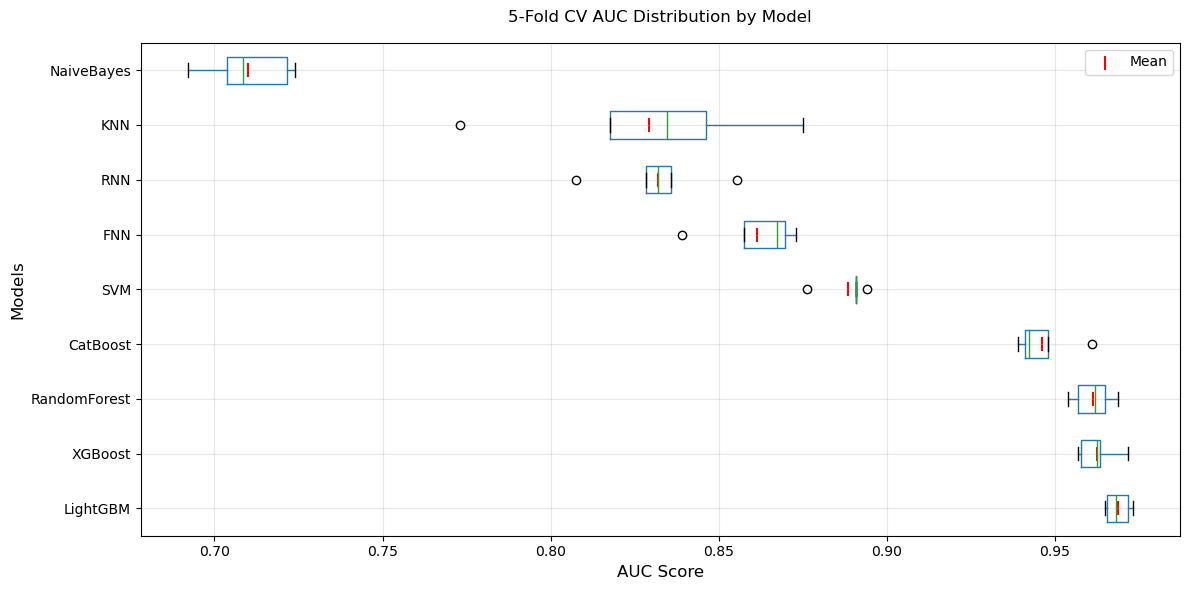


Note: Install scikit-posthocs for critical difference diagram
pip install scikit-posthocs


In [202]:
import numpy as np
import pandas as pd
from scipy.stats import friedmanchisquare, rankdata
import matplotlib.pyplot as plt
from itertools import combinations

# Your original data
data = {
    'RandomForest': [0.9619, 0.9649, 0.9538, 0.9567, 0.9688],
    'XGBoost': [0.9577, 0.9568, 0.9625, 0.9635, 0.9717],
    'LightGBM': [0.9682, 0.9649, 0.9653, 0.9731, 0.9718],
    'CatBoost': [0.9478, 0.9410, 0.9390, 0.9423, 0.9611],
    'SVM': [0.8762, 0.8908, 0.8908, 0.8908, 0.8940],
    'KNN': [0.8461, 0.8749, 0.8177, 0.8347, 0.7731],
    'NaiveBayes': [0.7085, 0.6921, 0.7217, 0.7037, 0.7239],
    'FNN': [0.8574, 0.8696, 0.8730, 0.8672, 0.8391],
    'RNN': [0.8358, 0.8319, 0.8553, 0.8283, 0.8075]
}

df = pd.DataFrame(data)

# 1. Corrected Friedman Test
print("=== Corrected Statistical Analysis ===")

# Transpose to rank within folds (rows)
ranks = df.apply(lambda row: rankdata(-row), axis=1)
ranks = pd.DataFrame(ranks.tolist(), columns=df.columns)  # <-- Conversion nécessaire

mean_ranks = ranks.mean().sort_values()

print("\n1. Model Ranking (Lower = Better):")
print(mean_ranks.round(2))


# Calculate Friedman test on ranks
friedman_stat, p_value = friedmanchisquare(*[ranks[col] for col in ranks.columns])
print(f"\n2. Friedman Test Results:\nχ² = {friedman_stat:.3f}, p = {p_value:.5f}")

# 2. Corrected Effect Sizes (Cliff's Delta)
def cliffs_delta(x, y):
    nx, ny = len(x), len(y)
    wins = sum((xi > yj) for xi in x for yj in y)
    losses = sum((xi < yj) for xi in x for yj in y)
    return (wins - losses) / (nx * ny)

print("\n3. Effect Sizes vs Top Model (LightGBM):")
top_model = 'LightGBM'
for model in df.columns:
    if model != top_model:
        delta = cliffs_delta(df[top_model], df[model])
        magnitude = "negligible" if abs(delta) < 0.147 else "small" if abs(delta) < 0.33 else "medium" if abs(delta) < 0.474 else "large"
        print(f"{top_model} vs {model:12}: δ = {delta:+.3f} ({magnitude})")

# 3. Performance Summary
print("\n4. Performance Summary (Sorted by Mean AUC):")
performance = df.agg(['mean', 'std']).T.sort_values('mean', ascending=False)
print(performance.round(4))

# 4. Visualization
plt.figure(figsize=(12, 6))
df[performance.index].boxplot(vert=False)
plt.title('5-Fold CV AUC Distribution by Model', pad=15)
plt.xlabel('AUC Score', fontsize=12)
plt.ylabel('Models', fontsize=12)
plt.grid(True, alpha=0.3)

# Add mean markers
for i, model in enumerate(performance.index):
    plt.scatter(performance.loc[model, 'mean'], i+1, 
                color='red', s=100, marker='|', label='Mean' if i==0 else "")
plt.legend()
plt.tight_layout()
plt.show()

# 5. Critical Difference Diagram (if scikit-posthocs installed)
try:
    from scikit_posthocs import plot_critical_difference
    plt.figure(figsize=(10, 4))
    plot_critical_difference(mean_ranks.values, mean_ranks.index)
    plt.title('Critical Difference Diagram', pad=15)
    plt.tight_layout()
    plt.show()
except ImportError:
    print("\nNote: Install scikit-posthocs for critical difference diagram")
    print("pip install scikit-posthocs")

### AUCs with error bars

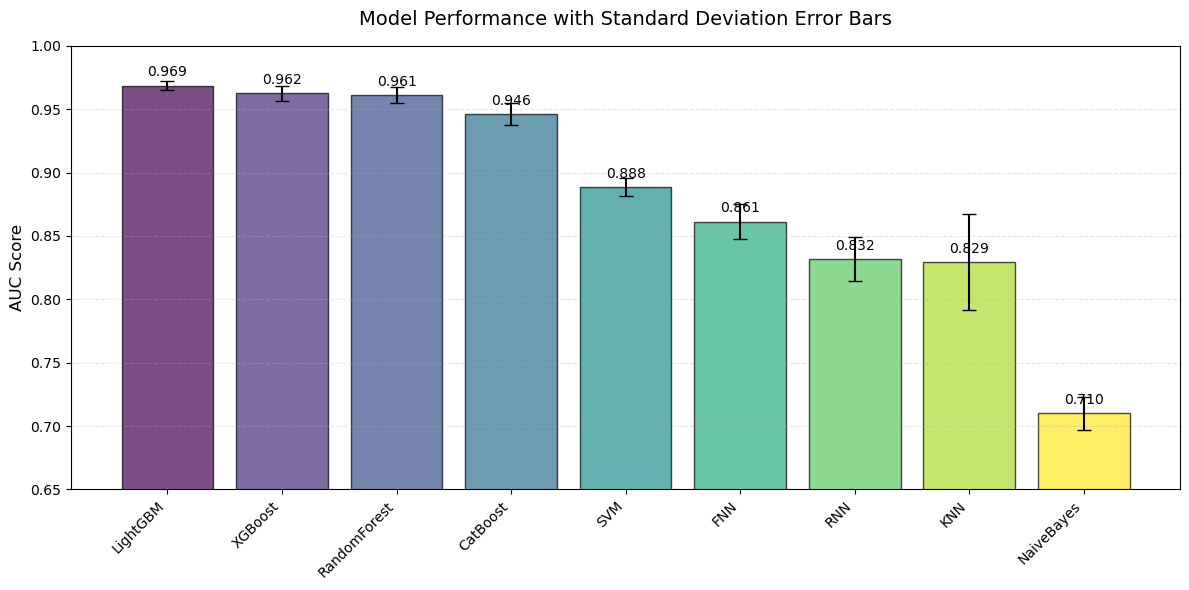

In [205]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your performance summary
models = ['LightGBM', 'XGBoost', 'RandomForest', 'CatBoost', 'SVM', 'FNN', 'RNN', 'KNN', 'NaiveBayes']
mean_auc = [0.9687, 0.9624, 0.9612, 0.9462, 0.8885, 0.8613, 0.8318, 0.8293, 0.7100]
std_dev = [0.0037, 0.0059, 0.0061, 0.0089, 0.0070, 0.0137, 0.0171, 0.0377, 0.0132]

# Create figure
plt.figure(figsize=(12, 6))

# Plot settings
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
x_pos = np.arange(len(models))

# Bar plot with error bars
bars = plt.bar(x_pos, mean_auc, yerr=std_dev, align='center', 
               alpha=0.7, color=colors, capsize=5, edgecolor='black')

# Customize plot
plt.xticks(x_pos, models, rotation=45, ha='right')
plt.ylabel('AUC Score', fontsize=12)
plt.title('Model Performance with Standard Deviation Error Bars', pad=15, fontsize=14)
plt.ylim(0.65, 1.0)  # Adjusted to show all error bars clearly
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

# Add value labels on top of bars
for bar, mean in zip(bars, mean_auc):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005, 
             f'{mean:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

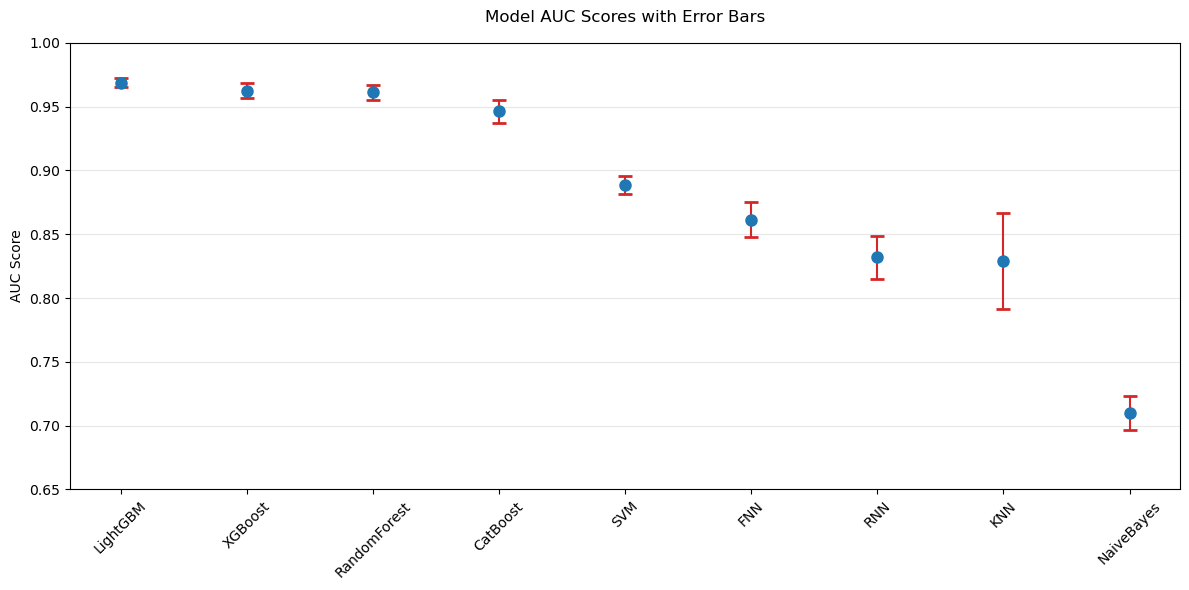

In [207]:
plt.figure(figsize=(12, 6))
plt.errorbar(x_pos, mean_auc, yerr=std_dev, fmt='o', 
             markersize=8, capsize=5, capthick=2, 
             color='tab:blue', ecolor='tab:red')
plt.xticks(x_pos, models, rotation=45)
plt.title('Model AUC Scores with Error Bars', pad=15)
plt.ylabel('AUC Score')
plt.grid(True, axis='y', alpha=0.3)
plt.ylim(0.65, 1.0)
plt.tight_layout()
plt.show()

### Nemenyi post hoc test (based on friedman test results)

#### install orange3

In [220]:
!pip install orange3



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/3.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.6 MB ? eta -:--:--
   -- ------------------------------------- 0.3/3.6 MB ? eta -:--:--
   -

  You can safely remove it manually.


#### script

=== Nemenyi Post-Hoc Test Results ===
Adjusted p-values matrix:
              LightGBM  XGBoost  RandomForest  CatBoost     SVM     FNN  \
LightGBM        1.0000   0.9997        0.9656    0.7267  0.3362  0.0918   
XGBoost         0.9997   1.0000        0.9997    0.9656  0.7267  0.3362   
RandomForest    0.9656   0.9997        1.0000    0.9997  0.9656  0.7267   
CatBoost        0.7267   0.9656        0.9997    1.0000  0.9997  0.9656   
SVM             0.3362   0.7267        0.9656    0.9997  1.0000  0.9997   
FNN             0.0918   0.3362        0.7267    0.9656  0.9997  1.0000   
KNN             0.0156   0.0918        0.3362    0.7267  0.9656  0.9997   
RNN             0.0017   0.0156        0.0918    0.3362  0.7267  0.9656   
NaiveBayes      0.0001   0.0017        0.0156    0.0918  0.3362  0.7267   

                 KNN     RNN  NaiveBayes  
LightGBM      0.0156  0.0017      0.0001  
XGBoost       0.0918  0.0156      0.0017  
RandomForest  0.3362  0.0918      0.0156  
CatBoost     

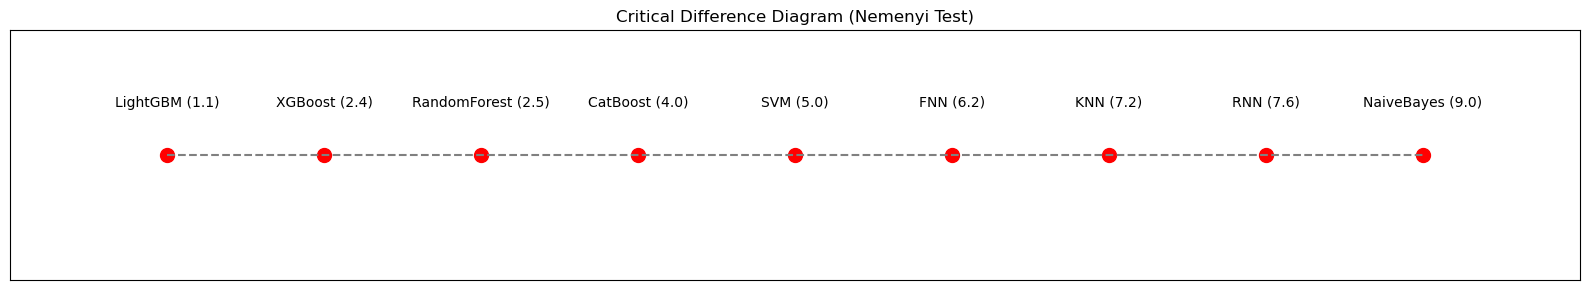

In [128]:
import numpy as np
import pandas as pd
import scikit_posthocs as sp
import matplotlib.pyplot as plt

# Your original Friedman test output
mean_ranks = pd.Series({
    'LightGBM': 1.1,
    'XGBoost': 2.4,
    'RandomForest': 2.5,
    'CatBoost': 4.0,
    'SVM': 5.0,
    'FNN': 6.2,
    'KNN': 7.2,
    'RNN': 7.6,
    'NaiveBayes': 9.0
})

# Simulate rank matrix (5 folds x 9 models) based on your mean ranks
n_folds = 5
rank_matrix = np.array([mean_ranks.rank(method='average')] * n_folds)

# Perform Nemenyi post-hoc test
nemenyi_results = sp.posthoc_nemenyi_friedman(rank_matrix)

# Format results for better readability
nemenyi_formatted = nemenyi_results.copy()
nemenyi_formatted.columns = mean_ranks.index
nemenyi_formatted.index = mean_ranks.index

print("=== Nemenyi Post-Hoc Test Results ===")
print("Adjusted p-values matrix:")
print(nemenyi_formatted.round(4))

# Critical Difference Diagram (Manual Implementation)
plt.figure(figsize=(16, 3))
y = 1  # Arbitrary y-position for the ranks
plt.hlines(y, 1, len(mean_ranks), linestyles='dashed', colors='gray')

# Plot each model's rank
for i, (model, rank) in enumerate(mean_ranks.items(), start=1):
    plt.scatter(i, y, color='red', s=100)
    plt.text(i, y + 0.02, f"{model} ({rank:.1f})", ha='center', va='bottom')

plt.yticks([])  # Hide y-axis
plt.xticks([])  # Hide x-axis
plt.xlim(0, len(mean_ranks) + 1)
plt.tight_layout()
plt.show()

In [108]:
import seaborn as sns

# 1. Heatmap with Significance Stars
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(
    nemenyi_formatted, 
    annot=True, 
    fmt=".4f",
    cmap="coolwarm",
    cbar=True,
    mask=nemenyi_formatted >= 0.05  # Highlight significant results
)
plt.title("Nemenyi Test Results\n(White cells: p < 0.05)", pad=20)
plt.tight_layout()

# Add significance stars manually
for i in range(len(nemenyi_formatted)):
    for j in range(len(nemenyi_formatted)):
        p = nemenyi_formatted.iloc[i,j]
        if p < 0.001:
            heatmap.text(j+0.5, i+0.3, "***", ha='center')
        elif p < 0.01:
            heatmap.text(j+0.5, i+0.3, "**", ha='center')
        elif p < 0.05:
            heatmap.text(j+0.5, i+0.3, "*", ha='center')

plt.show()

# 2. Improved Critical Difference Diagram
plt.figure(figsize=(12, 4))
y = 1
cd = 2.569  # Critical difference for N=9, k=5 (approximate)

# Draw the ranking line
plt.hlines(y, 0.5, len(mean_ranks)+0.5, colors='gray', linestyles='dashed')

# Plot models
for i, (model, rank) in enumerate(mean_ranks.items(), start=1):
    plt.scatter(i, y, s=200, color='skyblue', edgecolor='navy', zorder=3)
    plt.text(i, y+0.05, f"{model}\n({rank:.1f})", ha='center', va='bottom')

# Add CD bar
plt.hlines(y, 1, len(mean_ranks), color='red', alpha=0.3, linewidth=10)
plt.text(len(mean_ranks)/2+0.5, y-0.05, 
         f"Critical Difference = {cd:.2f}", 
         ha='center', va='top', color='red')

plt.xlim(0.5, len(mean_ranks)+0.5)
plt.ylim(0.8, 1.2)
plt.gca().axis('off')
plt.title("Critical Difference Diagram\n(Models not connected by red bar differ significantly)", pad=20)
plt.tight_layout()
plt.show()

NameError: name 'nemenyi_formatted' is not defined

<Figure size 1000x800 with 0 Axes>

## All features heatmap

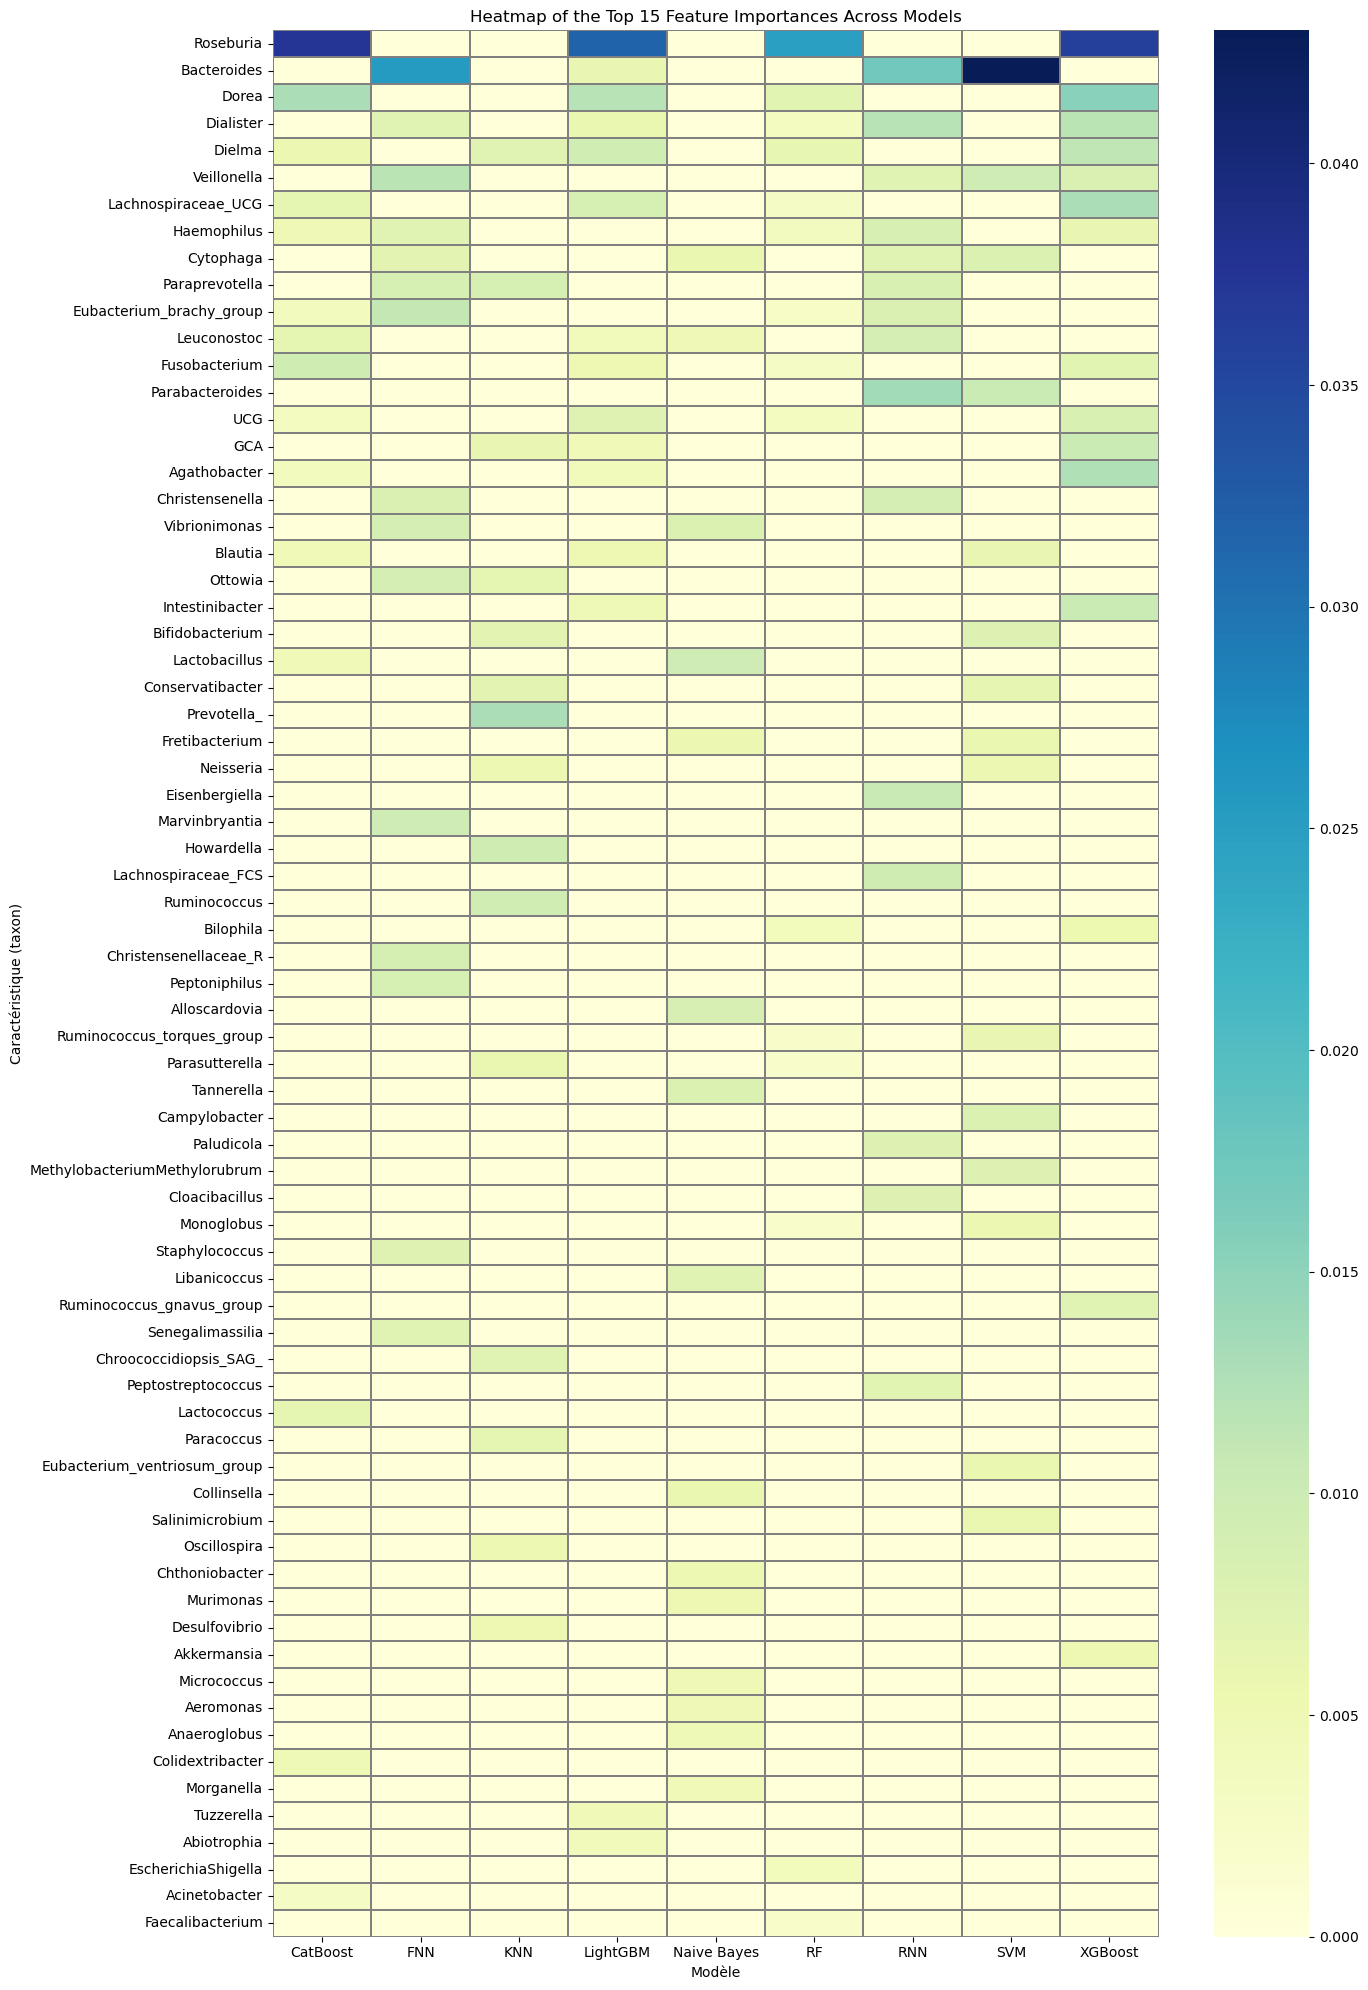

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dictionnaire contenant les importances moyennes pour chaque modèle
importance_dict = {
    'RNN': {
        'Bacteroides': 0.017180, 'Parabacteroides': 0.013589, 'Dialister': 0.012058,
        'Eisenbergiella': 0.010514, 'Lachnospiraceae_FCS': 0.009666, 'Leuconostoc': 0.009045,
        'Christensenella': 0.008994, 'Haemophilus': 0.008541, 'Paraprevotella': 0.008264,
        'Eubacterium_brachy_group': 0.008131, 'Paludicola': 0.007892, 'Cloacibacillus': 0.007713,
        'Veillonella': 0.007299, 'Cytophaga': 0.007064, 'Peptostreptococcus': 0.006920
    },
    'FNN': {
        'Bacteroides': 0.025486, 'Veillonella': 0.011612, 'Eubacterium_brachy_group': 0.011057,
        'Marvinbryantia': 0.009784, 'Ottowia': 0.009002, 'Vibrionimonas': 0.009002,
        'Christensenellaceae_R': 0.008846, 'Peptoniphilus': 0.008647, 'Paraprevotella': 0.008604,
        'Christensenella': 0.008150, 'Staphylococcus': 0.007420, 'Senegalimassilia': 0.007299,
        'Haemophilus': 0.007185, 'Dialister': 0.007064, 'Cytophaga': 0.006783
    },
    'Naive Bayes': {
        'Lactobacillus': 0.0099, 'Alloscardovia': 0.0085, 'Vibrionimonas': 0.0080,
        'Tannerella': 0.0080, 'Libanicoccus': 0.0073, 'Collinsella': 0.0059,
        'Cytophaga': 0.0059, 'Fretibacterium': 0.0057, 'Chthoniobacter': 0.0053,
        'Murimonas': 0.0052, 'Micrococcus': 0.0050, 'Leuconostoc': 0.0050,
        'Aeromonas': 0.0049, 'Anaeroglobus': 0.0048, 'Morganella': 0.0047
    },
    'KNN': {
        'Prevotella_': 0.012917, 'Howardella': 0.009709, 'Ruminococcus': 0.009526,
        'Paraprevotella': 0.008697, 'Dielma': 0.007220, 'Chroococcidiopsis_SAG_': 0.007189,
        'Bifidobacterium': 0.006873, 'Conservatibacter': 0.006720, 'Paracoccus': 0.006681,
        'Ottowia': 0.006677, 'GCA': 0.006115, 'Parasutterella': 0.005986,
        'Oscillospira': 0.005368, 'Neisseria': 0.005306, 'Desulfovibrio': 0.005107
    },
    'SVM': {
        'Bacteroides': 0.0430, 'Parabacteroides': 0.0102, 'Veillonella': 0.0099,
        'Cytophaga': 0.0079, 'Campylobacter': 0.0079, 'MethylobacteriumMethylorubrum': 0.0078,
        'Bifidobacterium': 0.0077, 'Conservatibacter': 0.0065, 'Blautia': 0.0062,
        'Ruminococcus_torques_group': 0.0061, 'Eubacterium_ventriosum_group': 0.0059,
        'Fretibacterium': 0.0059, 'Salinimicrobium': 0.0058, 'Monoglobus': 0.0056,
        'Neisseria': 0.0056
    },
    'CatBoost': {
        'Roseburia': 0.0373, 'Dorea': 0.0128, 'Fusobacterium': 0.0097,
        'Lactococcus': 0.0067, 'Lachnospiraceae_UCG': 0.0066, 'Leuconostoc': 0.0066,
        'Dielma': 0.0057, 'Haemophilus': 0.0049, 'Colidextribacter': 0.0048,
        'Blautia': 0.0047, 'Lactobacillus': 0.0045, 'Agathobacter': 0.0038,
        'Eubacterium_brachy_group': 0.0037, 'UCG': 0.0032, 'Acinetobacter': 0.0030
    },
    'LightGBM': {
        'Roseburia': 0.0316, 'Dorea': 0.0120, 'Dielma': 0.0095, 'Lachnospiraceae_UCG': 0.0086,
        'UCG': 0.0074, 'Bacteroides': 0.0061, 'Dialister': 0.0060, 'Fusobacterium': 0.0051,
        'Blautia': 0.0051, 'Intestinibacter': 0.0048, 'GCA': 0.0046, 'Tuzzerella': 0.0044,
        'Leuconostoc': 0.0043, 'Abiotrophia': 0.0041, 'Agathobacter': 0.0041
    },
    'XGBoost': {
        'Roseburia': 0.0360, 'Dorea': 0.0154, 'Lachnospiraceae_UCG': 0.0128,
        'Agathobacter': 0.0125, 'Dialister': 0.0116, 'Dielma': 0.0113, 'GCA': 0.0102,
        'Intestinibacter': 0.0101, 'UCG': 0.0083, 'Veillonella': 0.0082,
        'Ruminococcus_gnavus_group': 0.0073, 'Fusobacterium': 0.0070,
        'Haemophilus': 0.0062, 'Bilophila': 0.0054, 'Akkermansia': 0.0051
    },
    'RF': {
        'Roseburia': 0.0247, 'Dorea': 0.0070, 'Dielma': 0.0063, 'EscherichiaShigella': 0.0040,
        'Bilophila': 0.0039, 'Haemophilus': 0.0036, 'UCG': 0.0035, 'Dialister': 0.0033,
        'Fusobacterium': 0.0030, 'Lachnospiraceae_UCG': 0.0029, 'Eubacterium_brachy_group': 0.0025,
        'Ruminococcus_torques_group': 0.0022, 'Faecalibacterium': 0.0022,
        'Monoglobus': 0.0021, 'Parasutterella': 0.0021
    }
}

# Convertir le dictionnaire en DataFrame
df_list = []
for model, features in importance_dict.items():
    for feature, importance in features.items():
        df_list.append({'Model': model, 'Feature': feature, 'Importance': importance})

df = pd.DataFrame(df_list)

# Pivot table pour la heatmap
pivot_df = df.pivot_table(index='Feature', columns='Model', values='Importance', fill_value=0)

# Tri des caractéristiques selon leur importance moyenne globale
feature_order = pivot_df.mean(axis=1).sort_values(ascending=False).index
pivot_df = pivot_df.loc[feature_order]

# Tracer la heatmap
plt.figure(figsize=(14, 20))
sns.heatmap(pivot_df, cmap="YlGnBu", linewidths=0.3, linecolor='gray')
plt.title("Heatmap of the Top 15 Feature Importances Across Models")
plt.xlabel("Modèle")
plt.ylabel("Caractéristique (taxon)")
plt.tight_layout()
plt.show()


## Venn diagram of top tier models

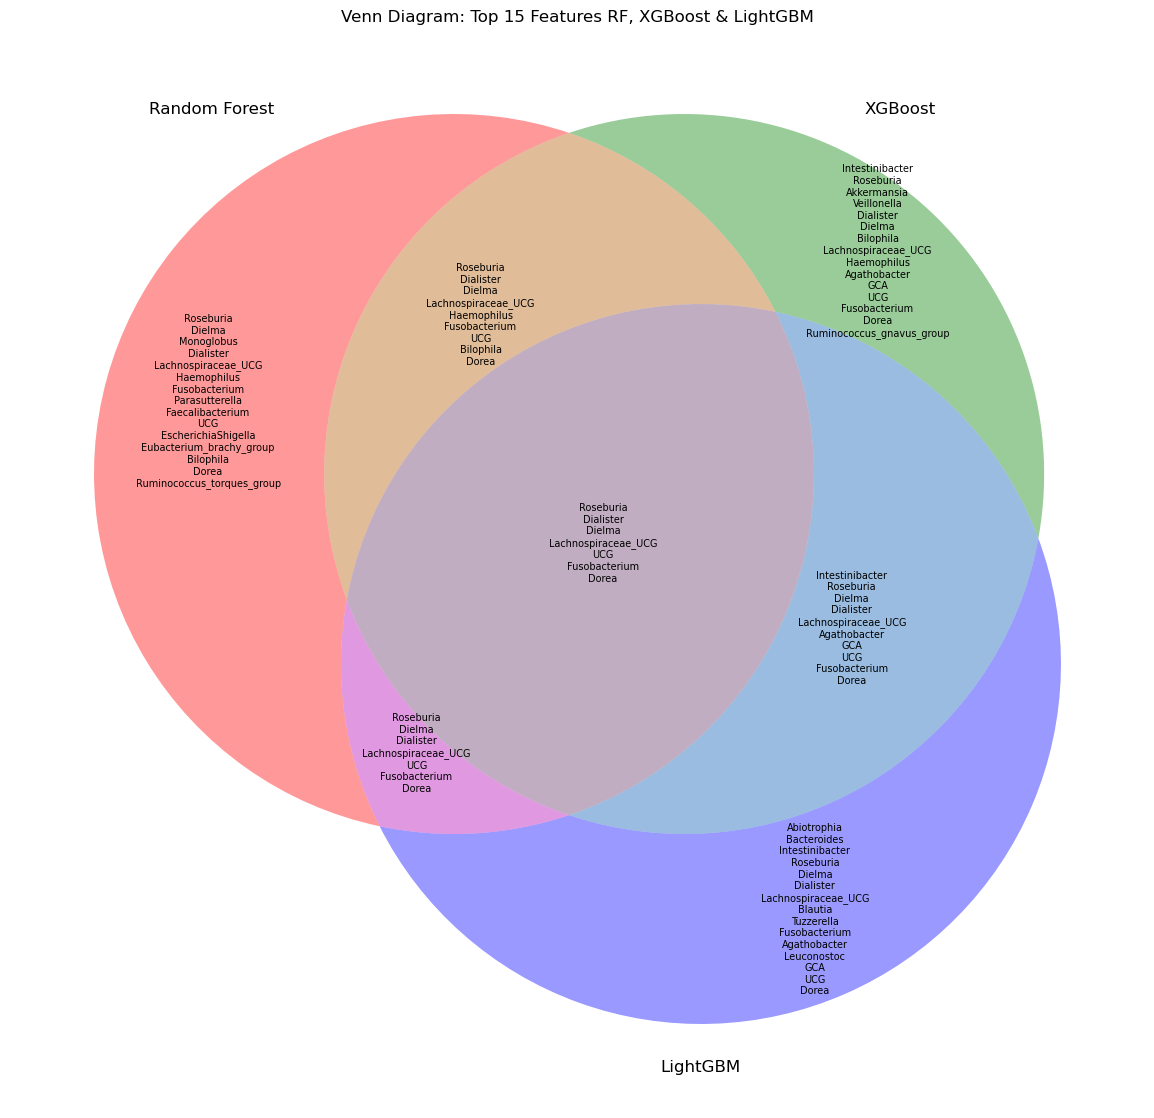

In [45]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

rf_features = {
    "Roseburia", "Dorea", "Dielma", "EscherichiaShigella", "Bilophila",
    "Haemophilus", "UCG", "Dialister", "Fusobacterium", "Lachnospiraceae_UCG",
    "Eubacterium_brachy_group", "Ruminococcus_torques_group", 
    "Faecalibacterium", "Monoglobus", "Parasutterella"
}

xgb_features = {
    "Roseburia", "Dorea", "Lachnospiraceae_UCG", "Agathobacter", "Dialister",
    "Dielma", "GCA", "Intestinibacter", "UCG", "Veillonella", 
    "Ruminococcus_gnavus_group", "Fusobacterium", "Haemophilus", 
    "Bilophila", "Akkermansia"
}

lgbm_features = {
    "Roseburia", "Dorea", "Dielma", "Lachnospiraceae_UCG", "UCG", 
    "Bacteroides", "Dialister", "Fusobacterium", "Blautia", "Intestinibacter",
    "GCA", "Tuzzerella", "Leuconostoc", "Abiotrophia", "Agathobacter"
}

plt.figure(figsize=(16,14))
venn = venn3([rf_features, xgb_features, lgbm_features], 
             set_labels=('Random Forest', 'XGBoost', 'LightGBM'))

def set_labels_text(venn_obj, sets, fontsize=1.5):
    for subset in ['100', '010', '001', '110', '101', '011', '111']:
        label = venn_obj.get_label_by_id(subset)
        if label:
            selected_sets = [sets[i] for i, bit in enumerate(subset) if bit == '1']
            intersection = set.intersection(*selected_sets)
            label.set_text("\n".join(intersection))
            label.set_fontsize(fontsize)  # ici on définit la taille de la police

set_labels_text(venn, [rf_features, xgb_features, lgbm_features], fontsize=7)

plt.title("Venn Diagram: Top 15 Features RF, XGBoost & LightGBM")
plt.show()


## Upset diagram

C:\Users\YLS\anaconda3\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
C:\Users\YLS\anaconda3\Lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

<Figure size 1200x800 with 0 Axes>

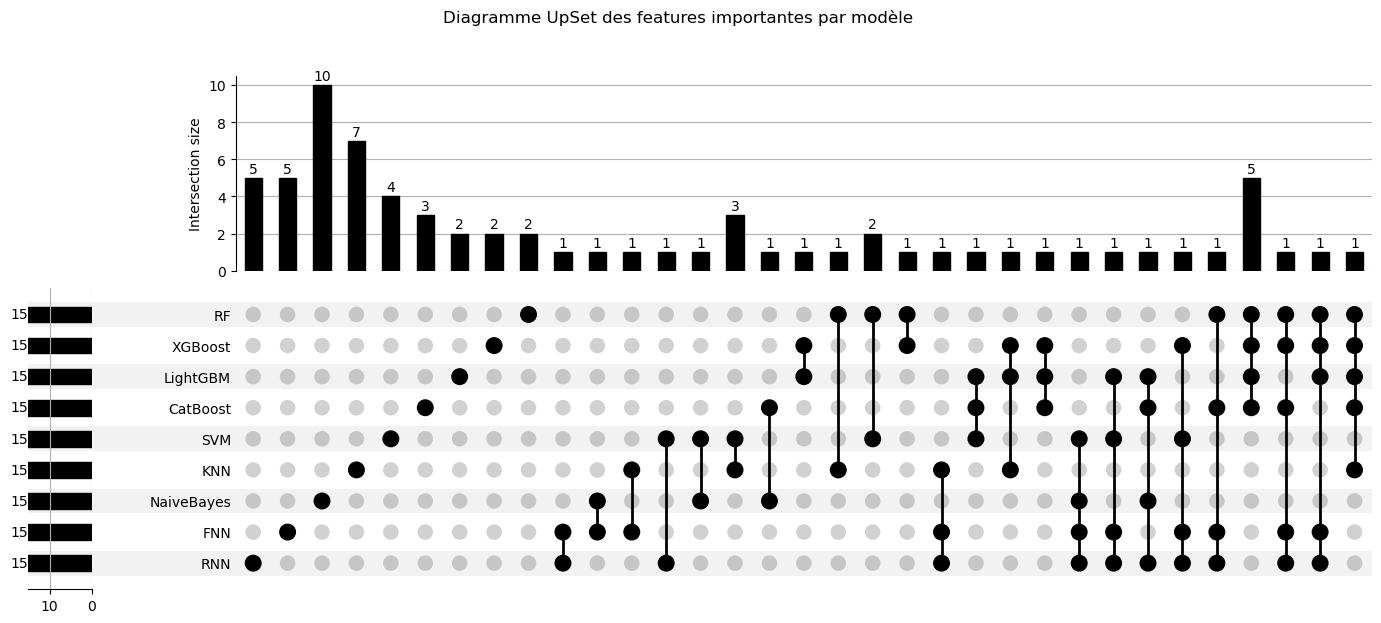

In [298]:
import pandas as pd
from upsetplot import UpSet
import matplotlib.pyplot as plt

features_dict = {
    'RNN': [
        'Bacteroides', 'Parabacteroides', 'Dialister', 'Eisenbergiella',
        'Lachnospiraceae_FCS', 'Leuconostoc', 'Christensenella', 'Haemophilus',
        'Paraprevotella', 'Eubacterium_brachy_group', 'Paludicola',
        'Cloacibacillus', 'Veillonella', 'Cytophaga', 'Peptostreptococcus'
    ],
    'FNN': [
        'Bacteroides', 'Veillonella', 'Eubacterium_brachy_group', 'Marvinbryantia',
        'Ottowia', 'Vibrionimonas', 'Christensenellaceae_R', 'Peptoniphilus',
        'Paraprevotella', 'Christensenella', 'Staphylococcus', 'Senegalimassilia',
        'Haemophilus', 'Dialister', 'Cytophaga'
    ],
    'NaiveBayes': [
        'Lactobacillus', 'Alloscardovia', 'Vibrionimonas', 'Tannerella',
        'Libanicoccus', 'Collinsella', 'Cytophaga', 'Fretibacterium',
        'Chthoniobacter', 'Murimonas', 'Micrococcus', 'Leuconostoc',
        'Aeromonas', 'Anaeroglobus', 'Morganella'
    ],
    'KNN': [
        'Prevotella_', 'Howardella', 'Ruminococcus', 'Paraprevotella',
        'Dielma', 'Chroococcidiopsis_SAG_', 'Bifidobacterium', 'Conservatibacter',
        'Paracoccus', 'Ottowia', 'GCA', 'Parasutterella', 'Oscillospira',
        'Neisseria', 'Desulfovibrio'
    ],
    'SVM': [
        'Bacteroides', 'Parabacteroides', 'Veillonella', 'Cytophaga',
        'Campylobacter', 'MethylobacteriumMethylorubrum', 'Bifidobacterium',
        'Conservatibacter', 'Blautia', 'Ruminococcus_torques_group',
        'Eubacterium_ventriosum_group', 'Fretibacterium', 'Salinimicrobium',
        'Monoglobus', 'Neisseria'
    ],
    'CatBoost': [
        'Roseburia', 'Dorea', 'Fusobacterium', 'Lactococcus', 'Lachnospiraceae_UCG',
        'Leuconostoc', 'Dielma', 'Haemophilus', 'Colidextribacter', 'Blautia',
        'Lactobacillus', 'Agathobacter', 'Eubacterium_brachy_group', 'UCG',
        'Acinetobacter'
    ],
    'LightGBM': [
        'Roseburia', 'Dorea', 'Dielma', 'Lachnospiraceae_UCG', 'UCG', 'Bacteroides',
        'Dialister', 'Fusobacterium', 'Blautia', 'Intestinibacter', 'GCA',
        'Tuzzerella', 'Leuconostoc', 'Abiotrophia', 'Agathobacter'
    ],
    'XGBoost': [
        'Roseburia', 'Dorea', 'Lachnospiraceae_UCG', 'Agathobacter', 'Dialister',
        'Dielma', 'GCA', 'Intestinibacter', 'UCG', 'Veillonella',
        'Ruminococcus_gnavus_group', 'Fusobacterium', 'Haemophilus', 'Bilophila',
        'Akkermansia'
    ],
    'RF': [
        'Roseburia', 'Dorea', 'Dielma', 'EscherichiaShigella', 'Bilophila',
        'Haemophilus', 'UCG', 'Dialister', 'Fusobacterium', 'Lachnospiraceae_UCG',
        'Eubacterium_brachy_group', 'Ruminococcus_torques_group',
        'Faecalibacterium', 'Monoglobus', 'Parasutterella'
    ],
}

all_features = set().union(*features_dict.values())

# DataFrame features x modèles, booléen si feature dans modèle
df = pd.DataFrame({
    model: [feature in features_dict[model] for feature in all_features]
    for model in features_dict
}, index=list(all_features))

# On doit convertir ce df en un DataFrame où chaque ligne est une feature
# avec colonnes booléennes, et on passe ce df à upsetplot (MultiIndex booléen)
# Mais upsetplot veut que l'index soit ce MultiIndex, donc :
df_bool = df.astype(bool)

# On transforme le DataFrame en MultiIndex booléen
multi_index = pd.MultiIndex.from_frame(df_bool)

# Créer un DataFrame avec cet index et une colonne 'count' = 1 pour chaque feature
df_for_upset = pd.DataFrame({'count': 1}, index=multi_index)

from upsetplot import UpSet

plt.figure(figsize=(12,8))
upset = UpSet(df_for_upset, subset_size='count', show_counts='%d', sort_by='degree')
upset.plot()
plt.suptitle("Diagramme UpSet des features importantes par modèle")
plt.show()


### Plot performance

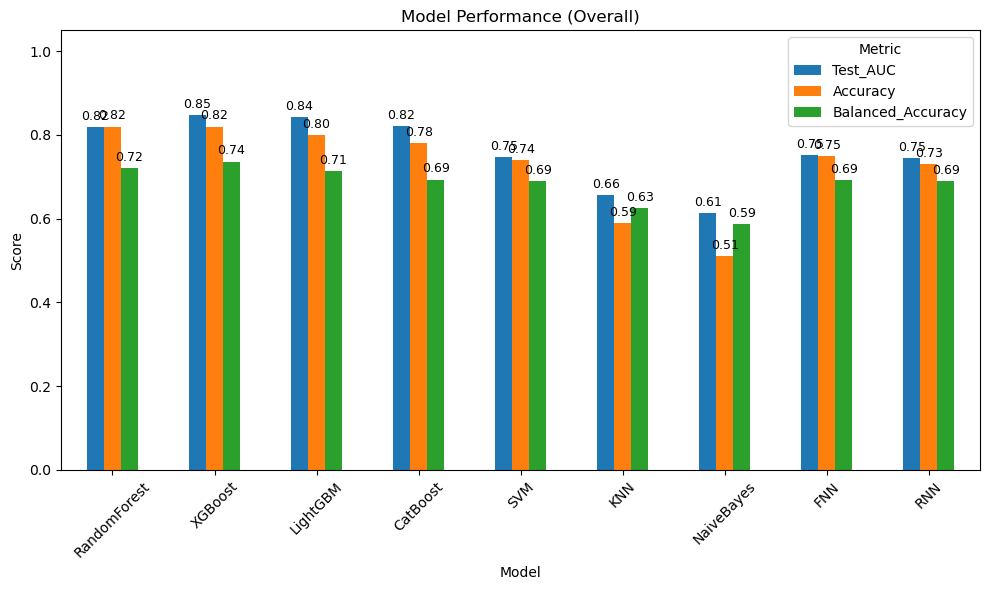

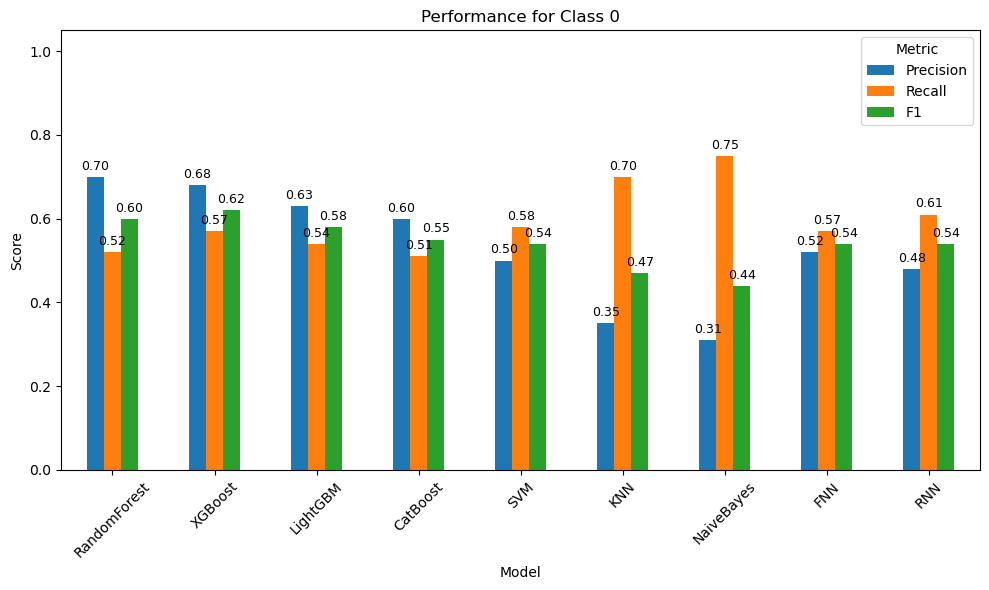

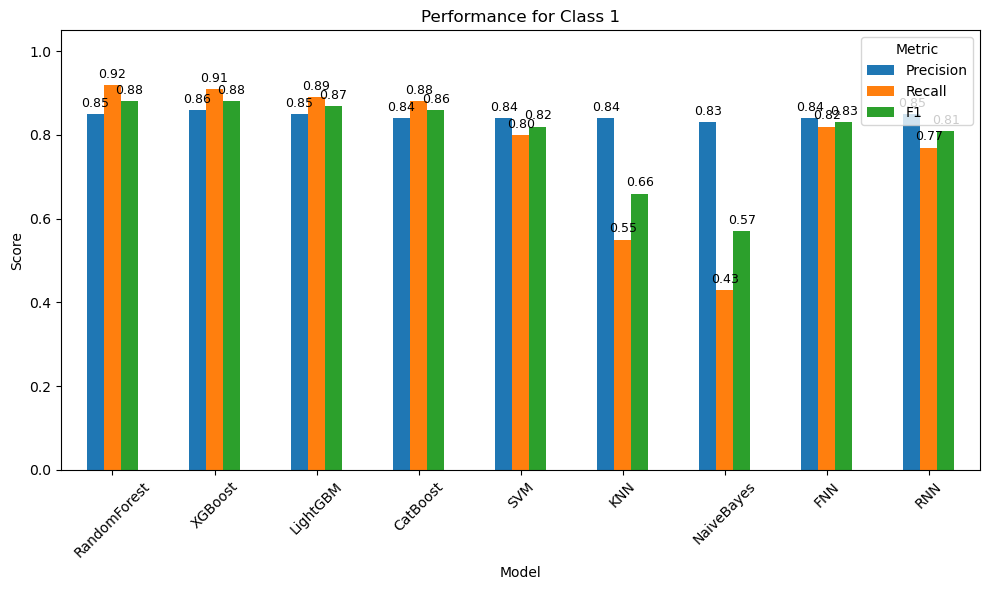

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ==== Data from your results ====
data_overall = {
    'Model': ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost', 'SVM', 'KNN', 'NaiveBayes', 'FNN', 'RNN'],
    'Test_AUC': [0.8186, 0.8475, 0.8427, 0.8214, 0.7462, 0.6558, 0.6132, 0.7524, 0.7457],
    'Accuracy': [0.82, 0.82, 0.80, 0.78, 0.74, 0.59, 0.51, 0.75, 0.73],
    'Balanced_Accuracy': [0.7219, 0.7365, 0.7137, 0.6935, 0.6890, 0.6256, 0.5878, 0.6920, 0.6908]
}

# Per-class metrics
data_class0 = {
    'Model': ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost', 'SVM', 'KNN', 'NaiveBayes', 'FNN', 'RNN'],
    'Precision': [0.70, 0.68, 0.63, 0.60, 0.50, 0.35, 0.31, 0.52, 0.48],
    'Recall': [0.52, 0.57, 0.54, 0.51, 0.58, 0.70, 0.75, 0.57, 0.61],
    'F1': [0.60, 0.62, 0.58, 0.55, 0.54, 0.47, 0.44, 0.54, 0.54]
}

data_class1 = {
    'Model': ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost', 'SVM', 'KNN', 'NaiveBayes', 'FNN', 'RNN'],
    'Precision': [0.85, 0.86, 0.85, 0.84, 0.84, 0.84, 0.83, 0.84, 0.85],
    'Recall': [0.92, 0.91, 0.89, 0.88, 0.80, 0.55, 0.43, 0.82, 0.77],
    'F1': [0.88, 0.88, 0.87, 0.86, 0.82, 0.66, 0.57, 0.83, 0.81]
}

df_overall = pd.DataFrame(data_overall)
df_class0 = pd.DataFrame(data_class0)
df_class1 = pd.DataFrame(data_class1)

# ==== Function to add labels ====
def add_labels(ax):
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3, fontsize=9)

# ==== Plot overall metrics ====
metrics_overall = ['Test_AUC', 'Accuracy', 'Balanced_Accuracy']
ax = df_overall.set_index('Model')[metrics_overall].plot(kind='bar', figsize=(10,6))
add_labels(ax)
plt.title('Model Performance (Overall)')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# ==== Function to plot per-class metrics ====
def plot_class_metrics(df, class_label):
    metrics = ['Precision', 'Recall', 'F1']
    ax = df.set_index('Model')[metrics].plot(kind='bar', figsize=(10,6))
    add_labels(ax)
    plt.title(f'Performance for Class {class_label}')
    plt.ylabel('Score')
    plt.ylim(0, 1.05)
    plt.xticks(rotation=45)
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()

# ==== Plot per-class ====
plot_class_metrics(df_class0, 0)  # Controls
plot_class_metrics(df_class1, 1)  # Patients


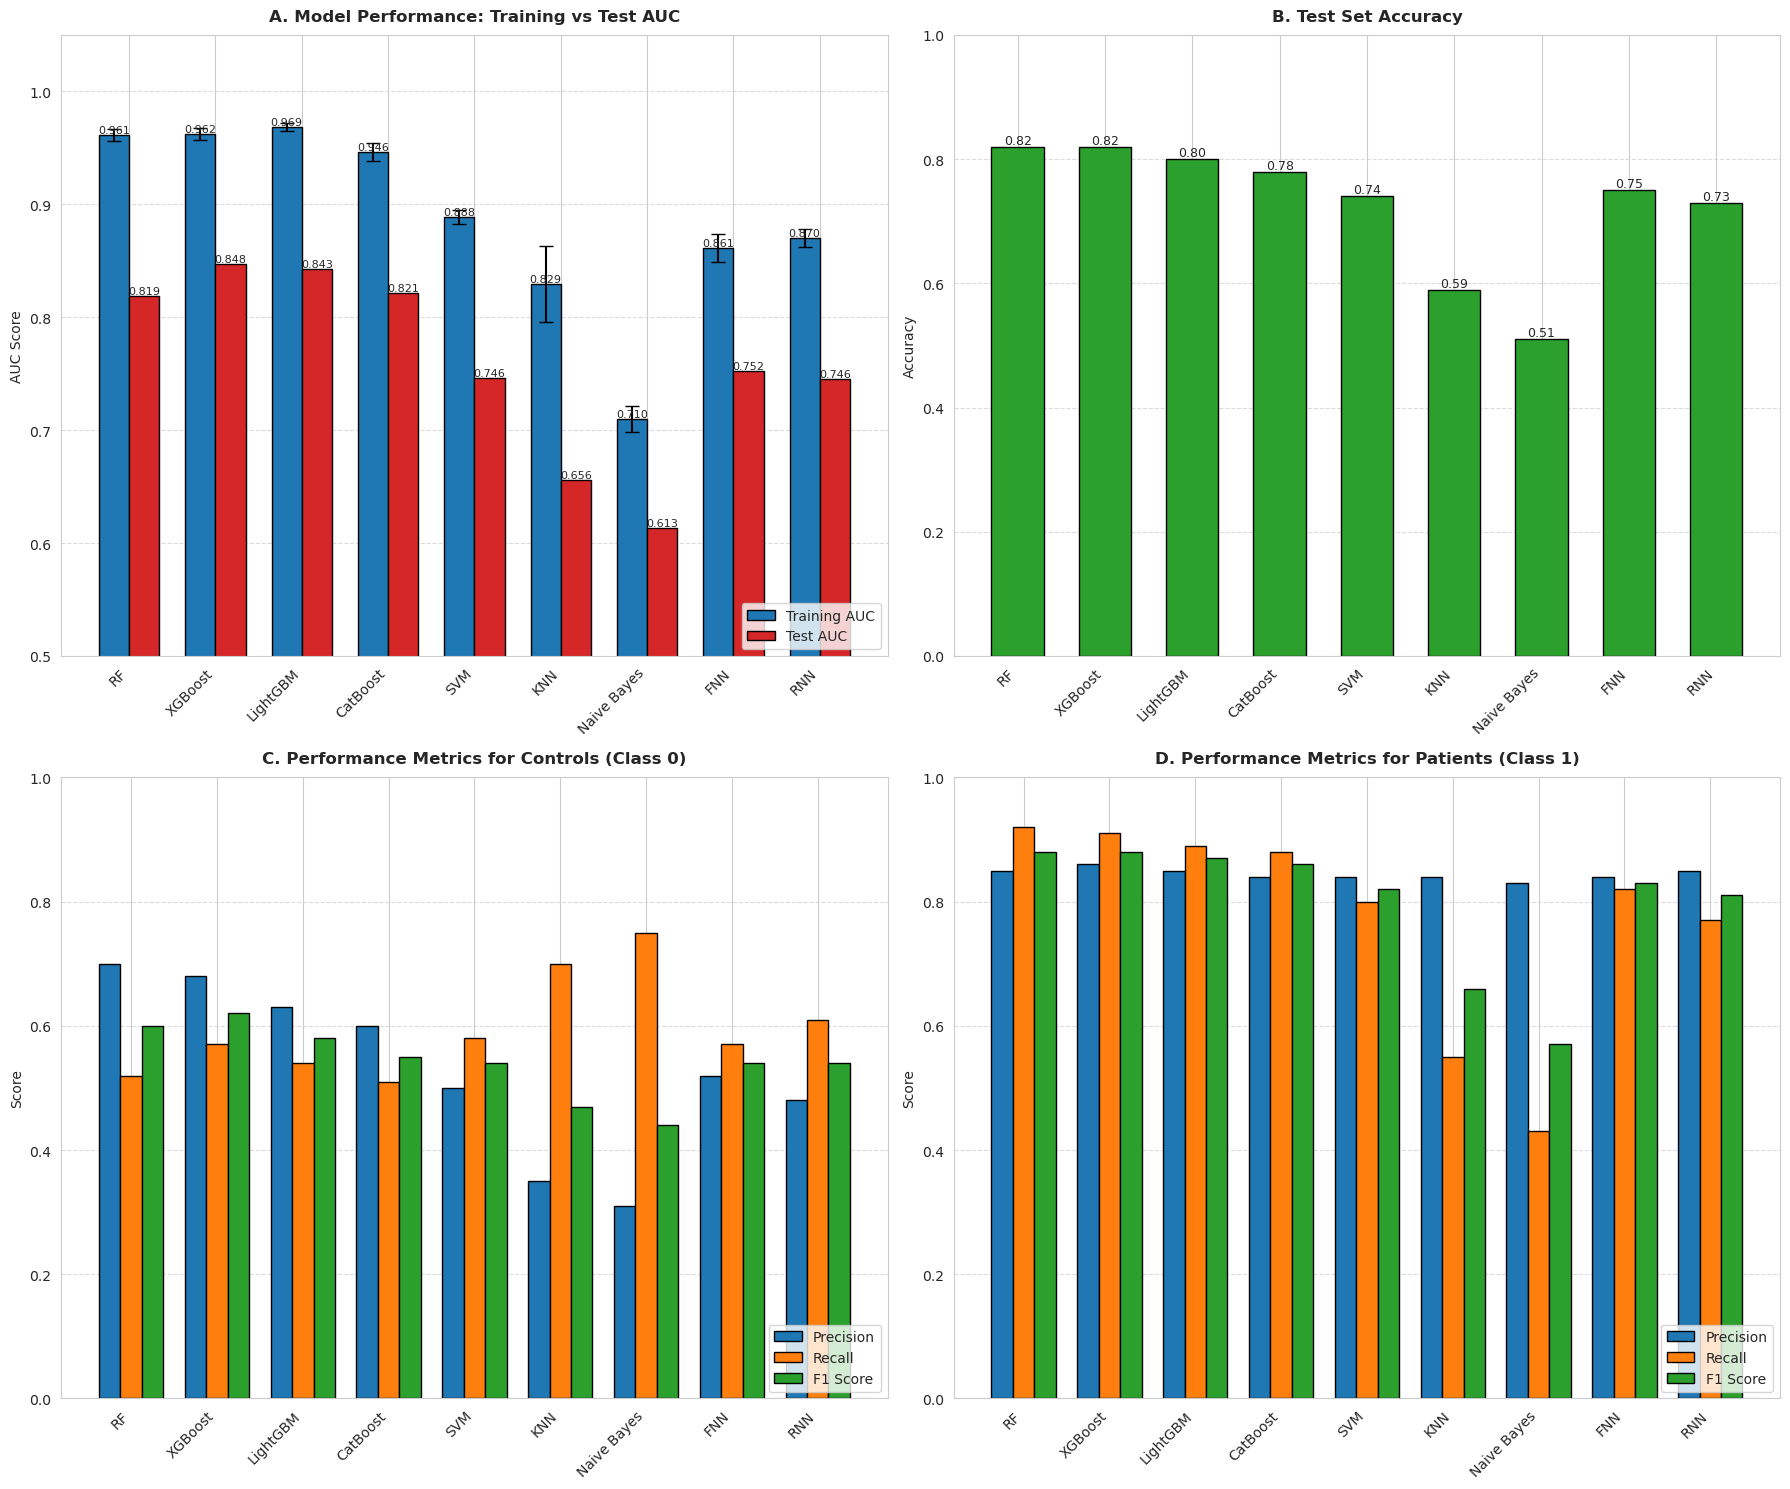

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data preparation
models = ['RF', 'XGBoost', 'LightGBM', 'CatBoost', 'SVM', 'KNN', 'Naive Bayes', 'FNN', 'RNN']

# Training metrics (from your CV results)
train_auc = [0.9612, 0.9624, 0.9686, 0.9462, 0.8885, 0.8293, 0.7100, 0.8612, 0.8702]
train_auc_std = [0.0054, 0.0053, 0.0033, 0.0080, 0.0063, 0.0337, 0.0118, 0.0122, 0.0076]

# Test set metrics
test_auc = [0.8186, 0.8475, 0.8427, 0.8214, 0.7462, 0.6558, 0.6132, 0.7524, 0.7457]
test_accuracy = [0.82, 0.82, 0.80, 0.78, 0.74, 0.59, 0.51, 0.75, 0.73]

# Class 0 (controls) metrics
class0_precision = [0.70, 0.68, 0.63, 0.60, 0.50, 0.35, 0.31, 0.52, 0.48]
class0_recall = [0.52, 0.57, 0.54, 0.51, 0.58, 0.70, 0.75, 0.57, 0.61]
class0_f1 = [0.60, 0.62, 0.58, 0.55, 0.54, 0.47, 0.44, 0.54, 0.54]

# Class 1 (patients) metrics
class1_precision = [0.85, 0.86, 0.85, 0.84, 0.84, 0.84, 0.83, 0.84, 0.85]
class1_recall = [0.92, 0.91, 0.89, 0.88, 0.80, 0.55, 0.43, 0.82, 0.77]
class1_f1 = [0.88, 0.88, 0.87, 0.86, 0.82, 0.66, 0.57, 0.83, 0.81]

# Set up the figure with professional styling
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.figure(figsize=(18, 15))

# Color scheme
train_color = '#1f77b4'  # Blue for training
test_color = '#d62728'   # Red for test
metric_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # For precision/recall/F1

# Plot 1: Training vs Test Performance
plt.subplot(2, 2, 1)
x = np.arange(len(models))
width = 0.35

# Training AUC with error bars
bars_train = plt.bar(x - width/2, train_auc, width, label='Training AUC', 
                    color=train_color, edgecolor='black', yerr=train_auc_std,
                    capsize=5)

# Test AUC
bars_test = plt.bar(x + width/2, test_auc, width, label='Test AUC', 
                   color=test_color, edgecolor='black')

plt.xticks(x, models, rotation=45, ha='right')
plt.ylabel('AUC Score')
plt.ylim(0.5, 1.05)
plt.title('A. Model Performance: Training vs Test AUC', pad=10, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for bar in bars_train + bars_test:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Plot 2: Test Accuracy
plt.subplot(2, 2, 2)
bars_acc = plt.bar(x, test_accuracy, width=0.6, color='#2ca02c', edgecolor='black')

plt.xticks(x, models, rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.0)
plt.title('B. Test Set Accuracy', pad=10, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for bar in bars_acc:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# Plot 3: Class 0 (Controls) Metrics
plt.subplot(2, 2, 3)
width = 0.25
bars1 = plt.bar(x - width, class0_precision, width, label='Precision', 
               color=metric_colors[0], edgecolor='black')
bars2 = plt.bar(x, class0_recall, width, label='Recall', 
               color=metric_colors[1], edgecolor='black')
bars3 = plt.bar(x + width, class0_f1, width, label='F1 Score', 
               color=metric_colors[2], edgecolor='black')

plt.xticks(x, models, rotation=45, ha='right')
plt.ylabel('Score')
plt.ylim(0.0, 1.0)
plt.title('C. Performance Metrics for Controls (Class 0)', pad=10, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 4: Class 1 (Patients) Metrics
plt.subplot(2, 2, 4)
bars1 = plt.bar(x - width, class1_precision, width, label='Precision', 
               color=metric_colors[0], edgecolor='black')
bars2 = plt.bar(x, class1_recall, width, label='Recall', 
               color=metric_colors[1], edgecolor='black')
bars3 = plt.bar(x + width, class1_f1, width, label='F1 Score', 
               color=metric_colors[2], edgecolor='black')

plt.xticks(x, models, rotation=45, ha='right')
plt.ylabel('Score')
plt.ylim(0.0, 1.0)
plt.title('D. Performance Metrics for Patients (Class 1)', pad=10, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and save
plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()